# ACCESS-OM3 and ACCESS-OM2 horizontal mean temperature drift from initial condition, vs depth and time

Related issue: https://github.com/ACCESS-Community-Hub/access-om3-25km-paper-1/issues/8

In [1]:
#parameters

### USER EDIT start
# esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
esm_file='/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json
Plot folder path:  /g/data/x77/amh157/access-om3-paper-figs/


In [16]:
import xarray as xr
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client
import cftime
import os
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from shapely import geometry
from matplotlib.patches import Patch
from textwrap import wrap
xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default

In [3]:
client = Client(threads_per_worker=1)
client

<Client: 'tcp://127.0.0.1:44603' processes=24 threads=24, memory=95.00 GiB>

### Load and plot data from ACCESS-OM3

In [4]:
exptname=os.path.basename(os.path.dirname(esm_file))

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [5]:
exptname

'25km-iaf-test-for-AK-expt-7df5ef4c'

In [6]:
variable = "temp"  # conservative temperature
model_all = datastore.search(variable=variable, frequency="1mon").to_dask(
    xarray_open_kwargs = dict(
        chunks={"xh": -1, "time": -1},
        decode_timedelta=True
    ),
    xarray_combine_by_coords_kwargs=dict(
        compat="override",
        data_vars="minimal",
        coords="minimal"
    )
)[variable]

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [7]:
##### ONLY NEEDED FOR 25km-iaf-test-for-AK-expt-7df5ef4c !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# omit latitudes with grid bug https://github.com/ACCESS-NRI/ocean_model_grid_generator/issues/7
model_all = model_all.isel(yh=slice(10, None))

# BUG: horizontal mean needs to be area-weighted - use xgcm?

In [8]:
%%time
model = model_all.mean('yh').mean('xh').load()

CPU times: user 39.4 s, sys: 11.7 s, total: 51 s
Wall time: 3min 3s


### Load and plot data from ACCESS-OM2
use control - see https://forum.access-hive.org.au/t/access-om2-control-experiments/258#p-747-ryf-7

In [11]:
# om2exptname = '025deg_jra55_ryf9091_gadi'
om2exptname = '025deg_jra55_iaf_omip2_cycle1'
datastore = intake.cat.access_nri[om2exptname]

In [12]:
# for 025deg_jra55_ryf9091_gadi
# variable = "temp"  # NB: using top level of annual-mean 3D temp, as surface_temp not available for 025deg_jra55_ryf9091_gadi, and also has monthly data only for 1900-1903, and 2300-, with annual data in the gap
# frequency = "1yr"

# for 025deg_jra55_iaf_omip2_cycle1
variable = "temp"
frequency = "1mon"

om2model_all = datastore.search(variable=variable, frequency=frequency).to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    ),
    xarray_combine_by_coords_kwargs=dict(
        compat="override",
        data_vars="minimal",
        coords="minimal"
    )
)[variable]

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


# BUG: horizontal mean needs to be area-weighted - use xgcm?

In [13]:
%%time
om2model = om2model_all.mean('yt_ocean').mean('xt_ocean').load()

CPU times: user 2min 30s, sys: 24 s, total: 2min 54s
Wall time: 6min 41s


Text(0.5, 1.0, 'ACCESS-OM3')

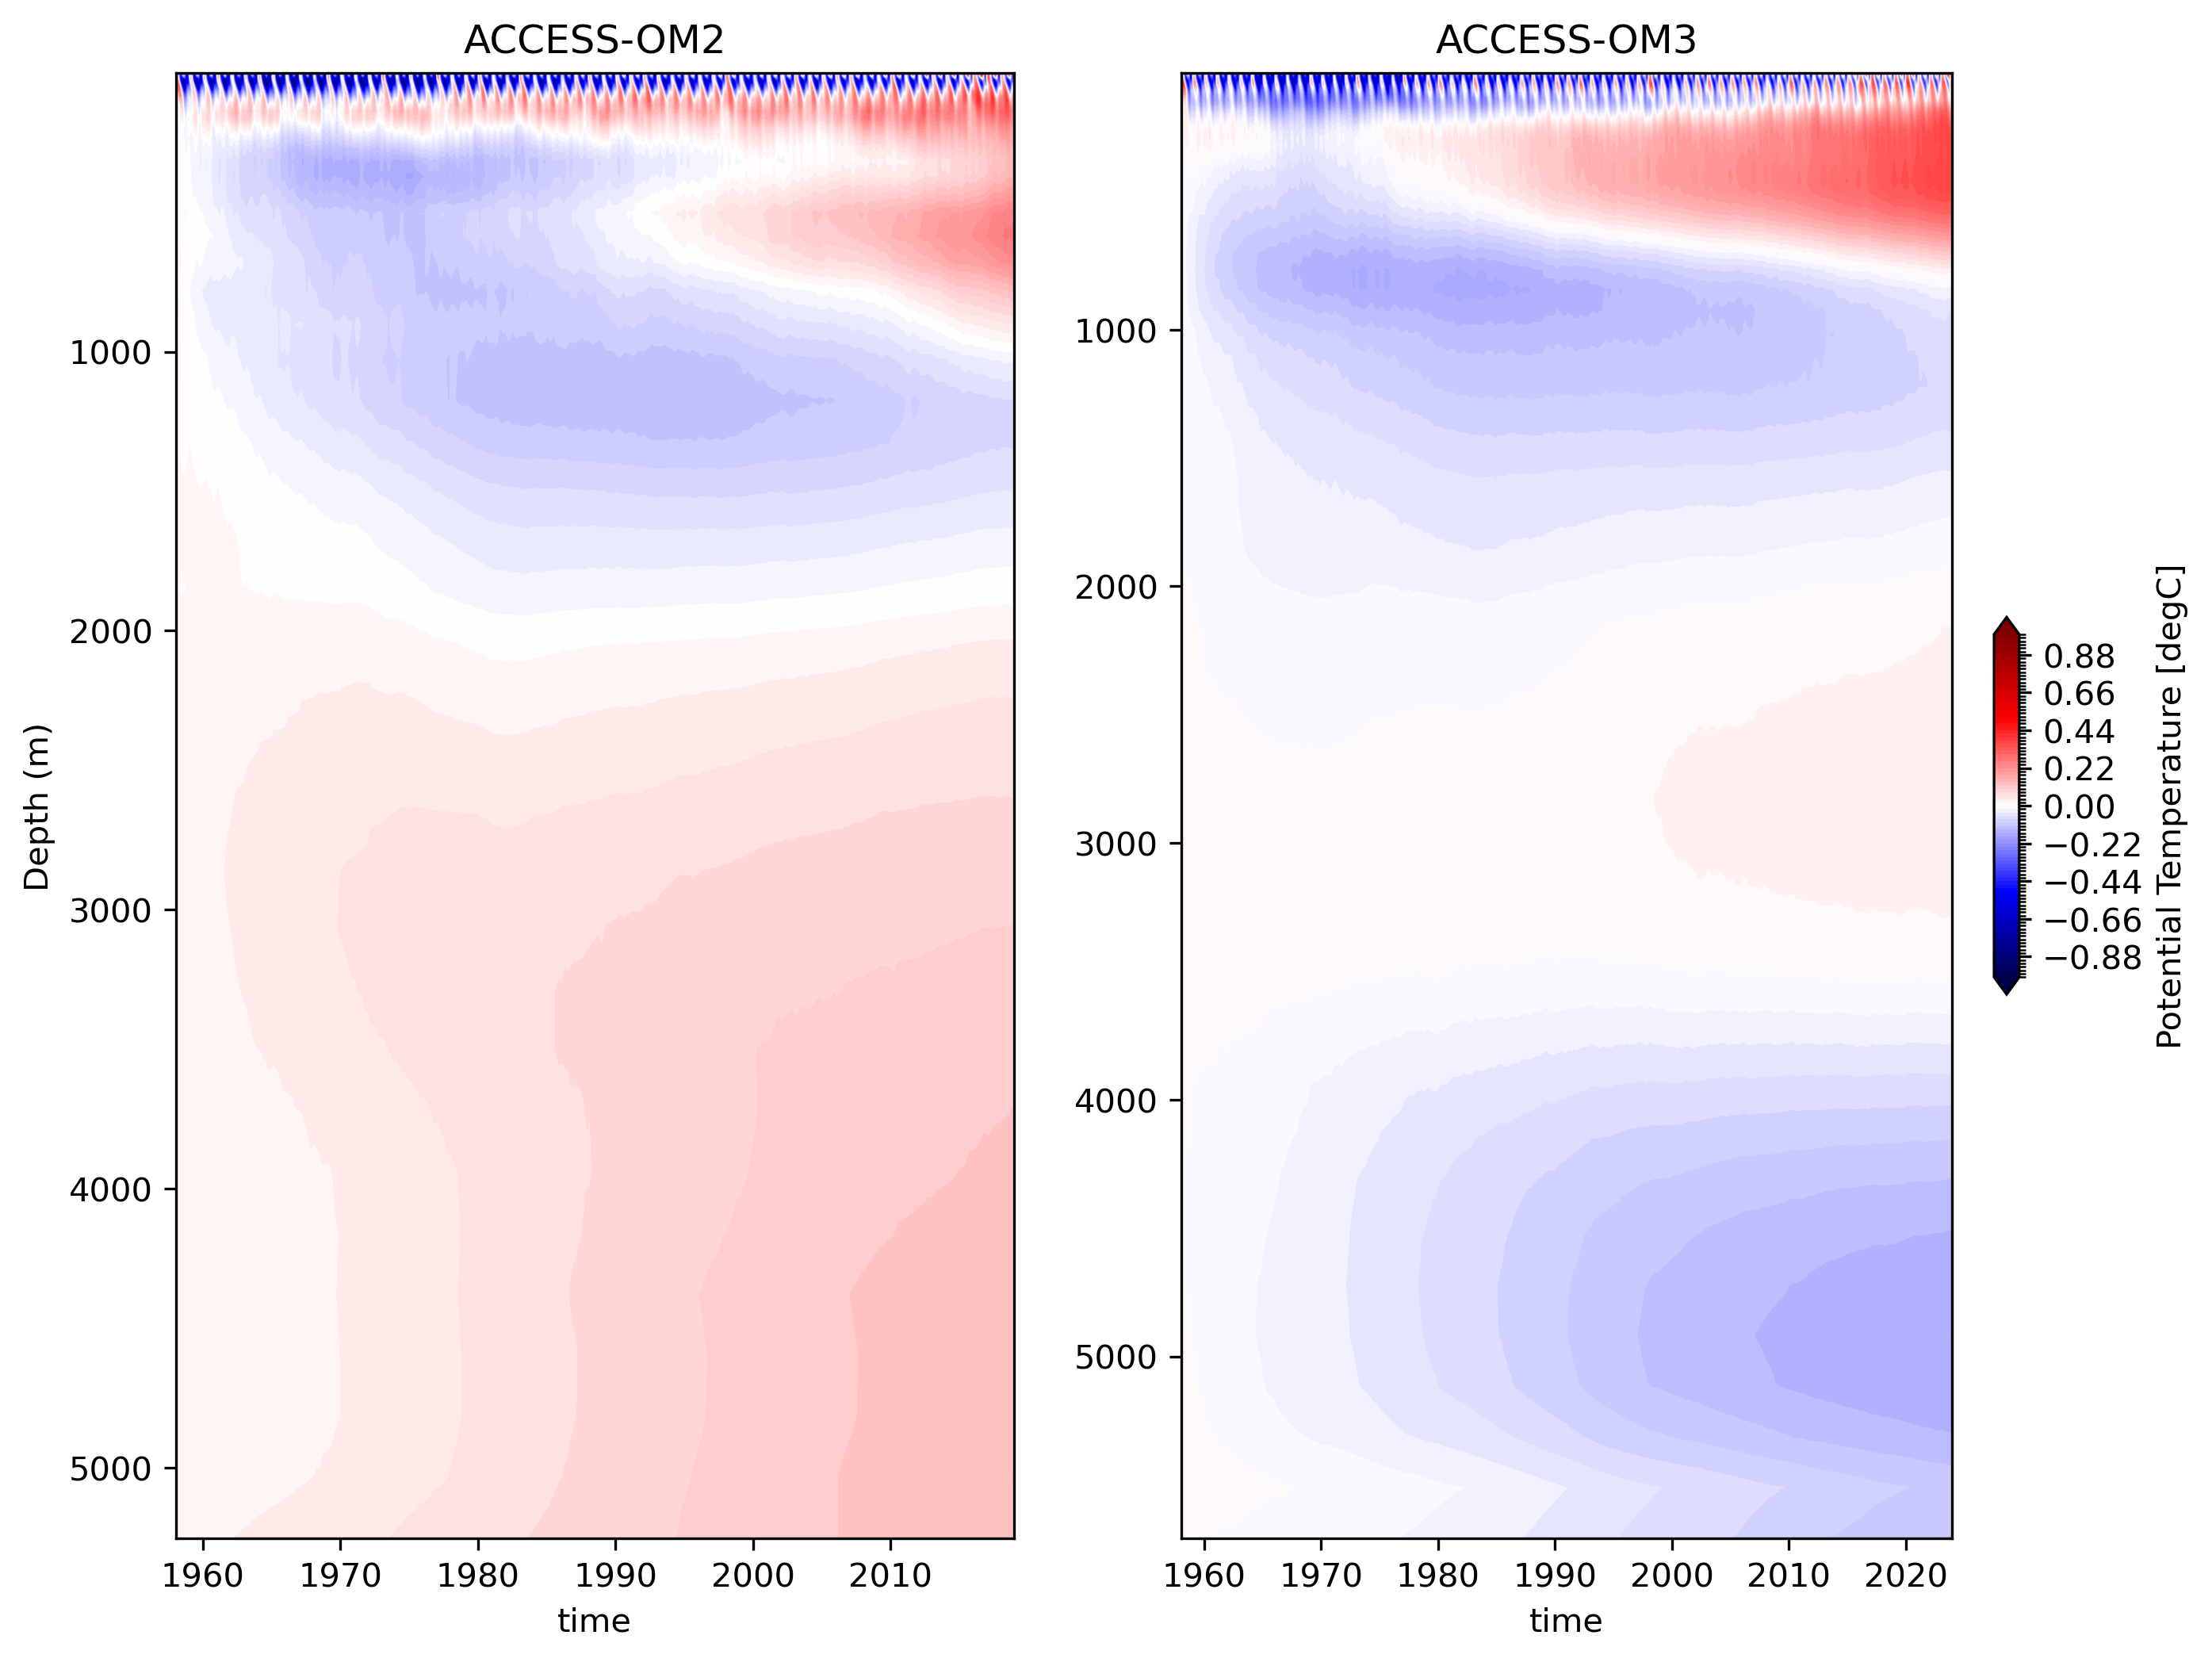

In [24]:
plt.figure(figsize=(10,8))

plt.subplot(121)
(om2model-om2model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    # extend="both",
    cmap='seismic',
    add_colorbar=False,
    #cbar_kwargs={"label": "\n".join(wrap(f"{om2model.attrs['long_name']} [{om2model.attrs['units']}]", 45)),
    #             "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.gca().invert_yaxis()
#plt.title("\n".join(wrap(f"UNWEIGHTED Horizontal mean {om2model.attrs['long_name']} drift from initial condition in {om2exptname}", 60)))
plt.title('ACCESS-OM2')
plt.ylabel('Depth (m)')

plt.subplot(122)
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    # extend="both",
    extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.ylabel('')
plt.gca().invert_yaxis()
#plt.title("\n".join(wrap(f"UNWEIGHTED Horizontal mean {model.attrs['long_name']} drift from initial condition in {exptname}", 60)))
plt.title('ACCESS-OM3')

# Regional Analysis

We start by defining a bunch of boxes that we can analyse 

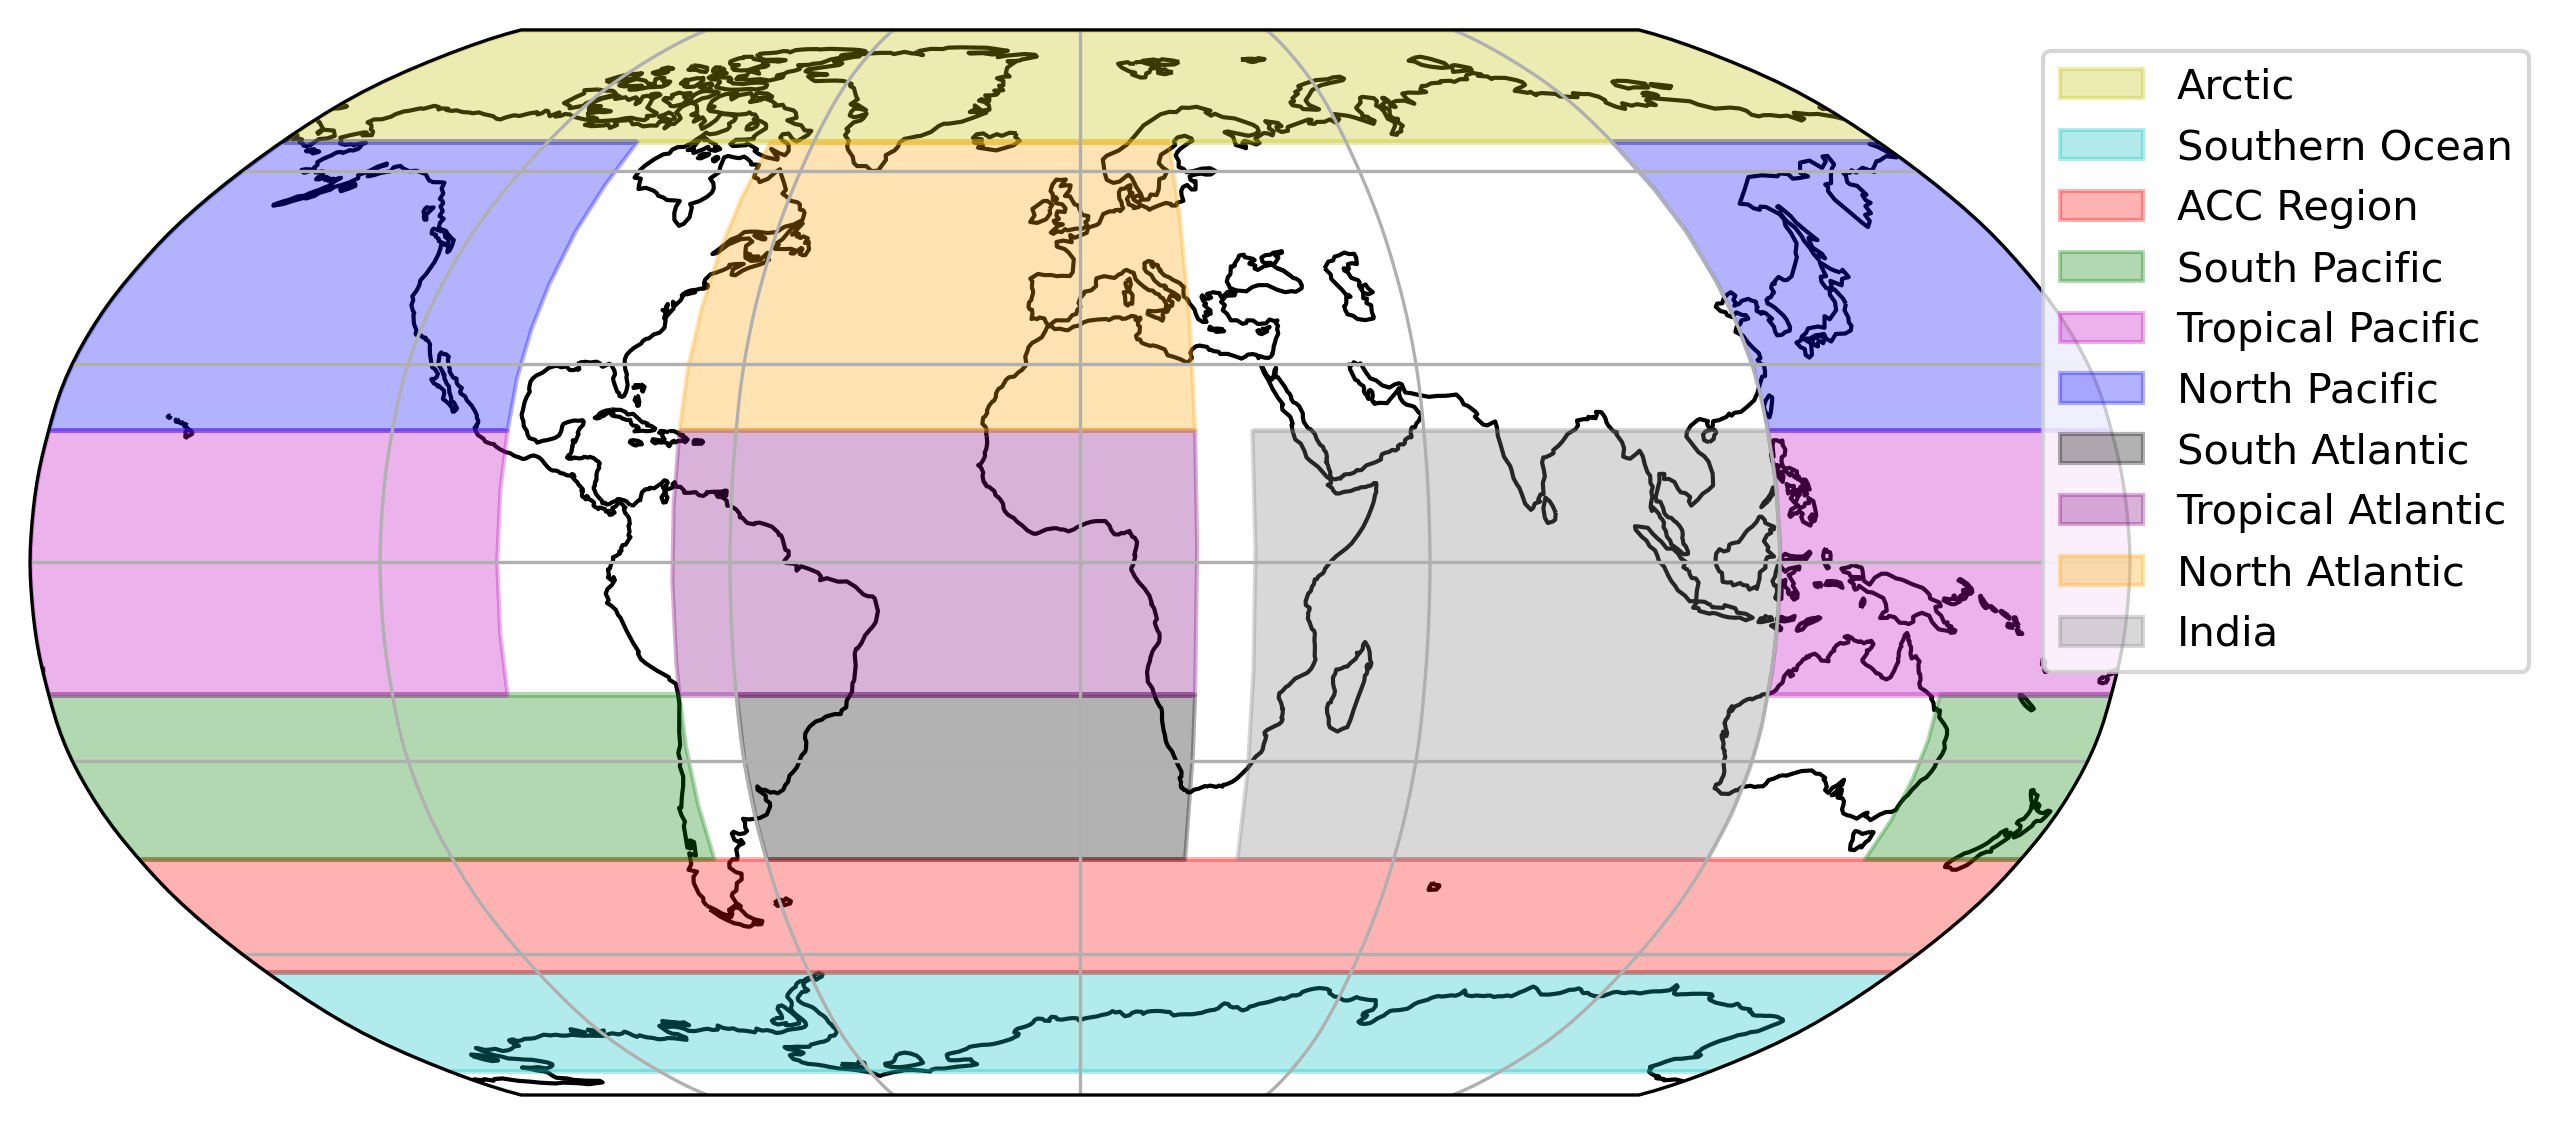

In [64]:
fig = plt.figure(figsize=(10, 4))

ax = plt.axes(position=[0.05,0.05,0.7,0.9], projection=ccrs.Robinson())

ax.coastlines(resolution="110m")
ax.gridlines(draw_labels=False)

#Arctic
arctic = [-180, 180, 65, 90]
geom = geometry.box(minx=arctic[0],maxx=arctic[1],miny=arctic[2],maxy=arctic[3])
ax.add_geometries([geom], crs=ccrs.PlateCarree(), color='y',alpha=0.3)

#Southern Ocean
so = [-180, 180, -82, -63]
geom = geometry.box(minx=so[0],maxx=so[1],miny=so[2],maxy=so[3])
ax.add_geometries([geom], crs=ccrs.PlateCarree(), color='c',alpha=0.3)

#ACC
acc = [-180, 180, -63, -45]
geom = geometry.box(minx=acc[0],maxx=acc[1],miny=acc[2],maxy=acc[3])
ax.add_geometries([geom], crs=ccrs.PlateCarree(), color='r',alpha=0.3)

# Southern Pacific
spac = [-210, -70, -45, -20]
geom = geometry.box(minx=spac[0],maxx=spac[1],miny=spac[2],maxy=spac[3])
ax.add_geometries([geom], crs=ccrs.PlateCarree(), color='g',alpha=0.3)

#Tropical Pacific
tatl = [-240, -100, -20, 20]
geom = geometry.box(minx=tpac[0],maxx=tpac[1],miny=tpac[2],maxy=tpac[3])
ax.add_geometries([geom], crs=ccrs.PlateCarree(), color='m',alpha=0.3)

# North Pacific
npac = [-240, -100, 20, 65]
geom = geometry.box(minx=npac[0],maxx=npac[1],miny=npac[2],maxy=npac[3])
ax.add_geometries([geom], crs=ccrs.PlateCarree(), color='b',alpha=0.3)

# South Atlantic
satl = [-60, 20, -45, -20]
geom = geometry.box(minx=satl[0],maxx=satl[1],miny=satl[2],maxy=satl[3])
ax.add_geometries([geom], crs=ccrs.PlateCarree(), color='k',alpha=0.3)

#Tropical Atlantic
tatl = [-70, 20, -20, 20]
geom = geometry.box(minx=tatl[0],maxx=tatl[1],miny=tatl[2],maxy=tatl[3])
ax.add_geometries([geom], crs=ccrs.PlateCarree(), color='purple',alpha=0.3)

# North Atlantic
natl = [-70, 20, 20, 65]
geom = geometry.box(minx=natl[0],maxx=natl[1],miny=natl[2],maxy=natl[3])
ax.add_geometries([geom], crs=ccrs.PlateCarree(), color='orange',alpha=0.3)

# Indian
ind = [30, 120, -45, 20]
geom = geometry.box(minx=ind[0],maxx=ind[1],miny=ind[2],maxy=ind[3])
ax.add_geometries([geom], crs=ccrs.PlateCarree(), color='gray',alpha=0.3)

legend_elements = [Patch(color='y',alpha=0.3,label='Arctic'), 
                   Patch(color='c',alpha=0.3,label='Southern Ocean'),
                   Patch(color='r',alpha=0.3,label='ACC Region'),
                   Patch(color='g',alpha=0.3,label='South Pacific'),
                   Patch(color='m',alpha=0.3,label='Tropical Pacific'),
                   Patch(color='b',alpha=0.3,label='North Pacific'),
                   Patch(color='k',alpha=0.3,label='South Atlantic'),
                   Patch(color='purple',alpha=0.3,label='Tropical Atlantic'),
                   Patch(color='orange',alpha=0.3,label='North Atlantic'),
                   Patch(color='gray',alpha=0.3,label='India')]

ax.legend(handles=legend_elements, bbox_to_anchor=(1.2, 1.00))

## Arctic

In [44]:
om2model = om2model_all.sel(xt_ocean=slice(arctic[0],arctic[1])).sel(yt_ocean=slice(arctic[2],arctic[3])).mean('yt_ocean').mean('xt_ocean').load()
model = model_all.sel(xh=slice(arctic[0],arctic[1])).sel(yh=slice(arctic[2],arctic[3])).mean('yh').mean('xh').load()

Text(0.5, 1.0, 'Arctic: ACCESS-OM3')

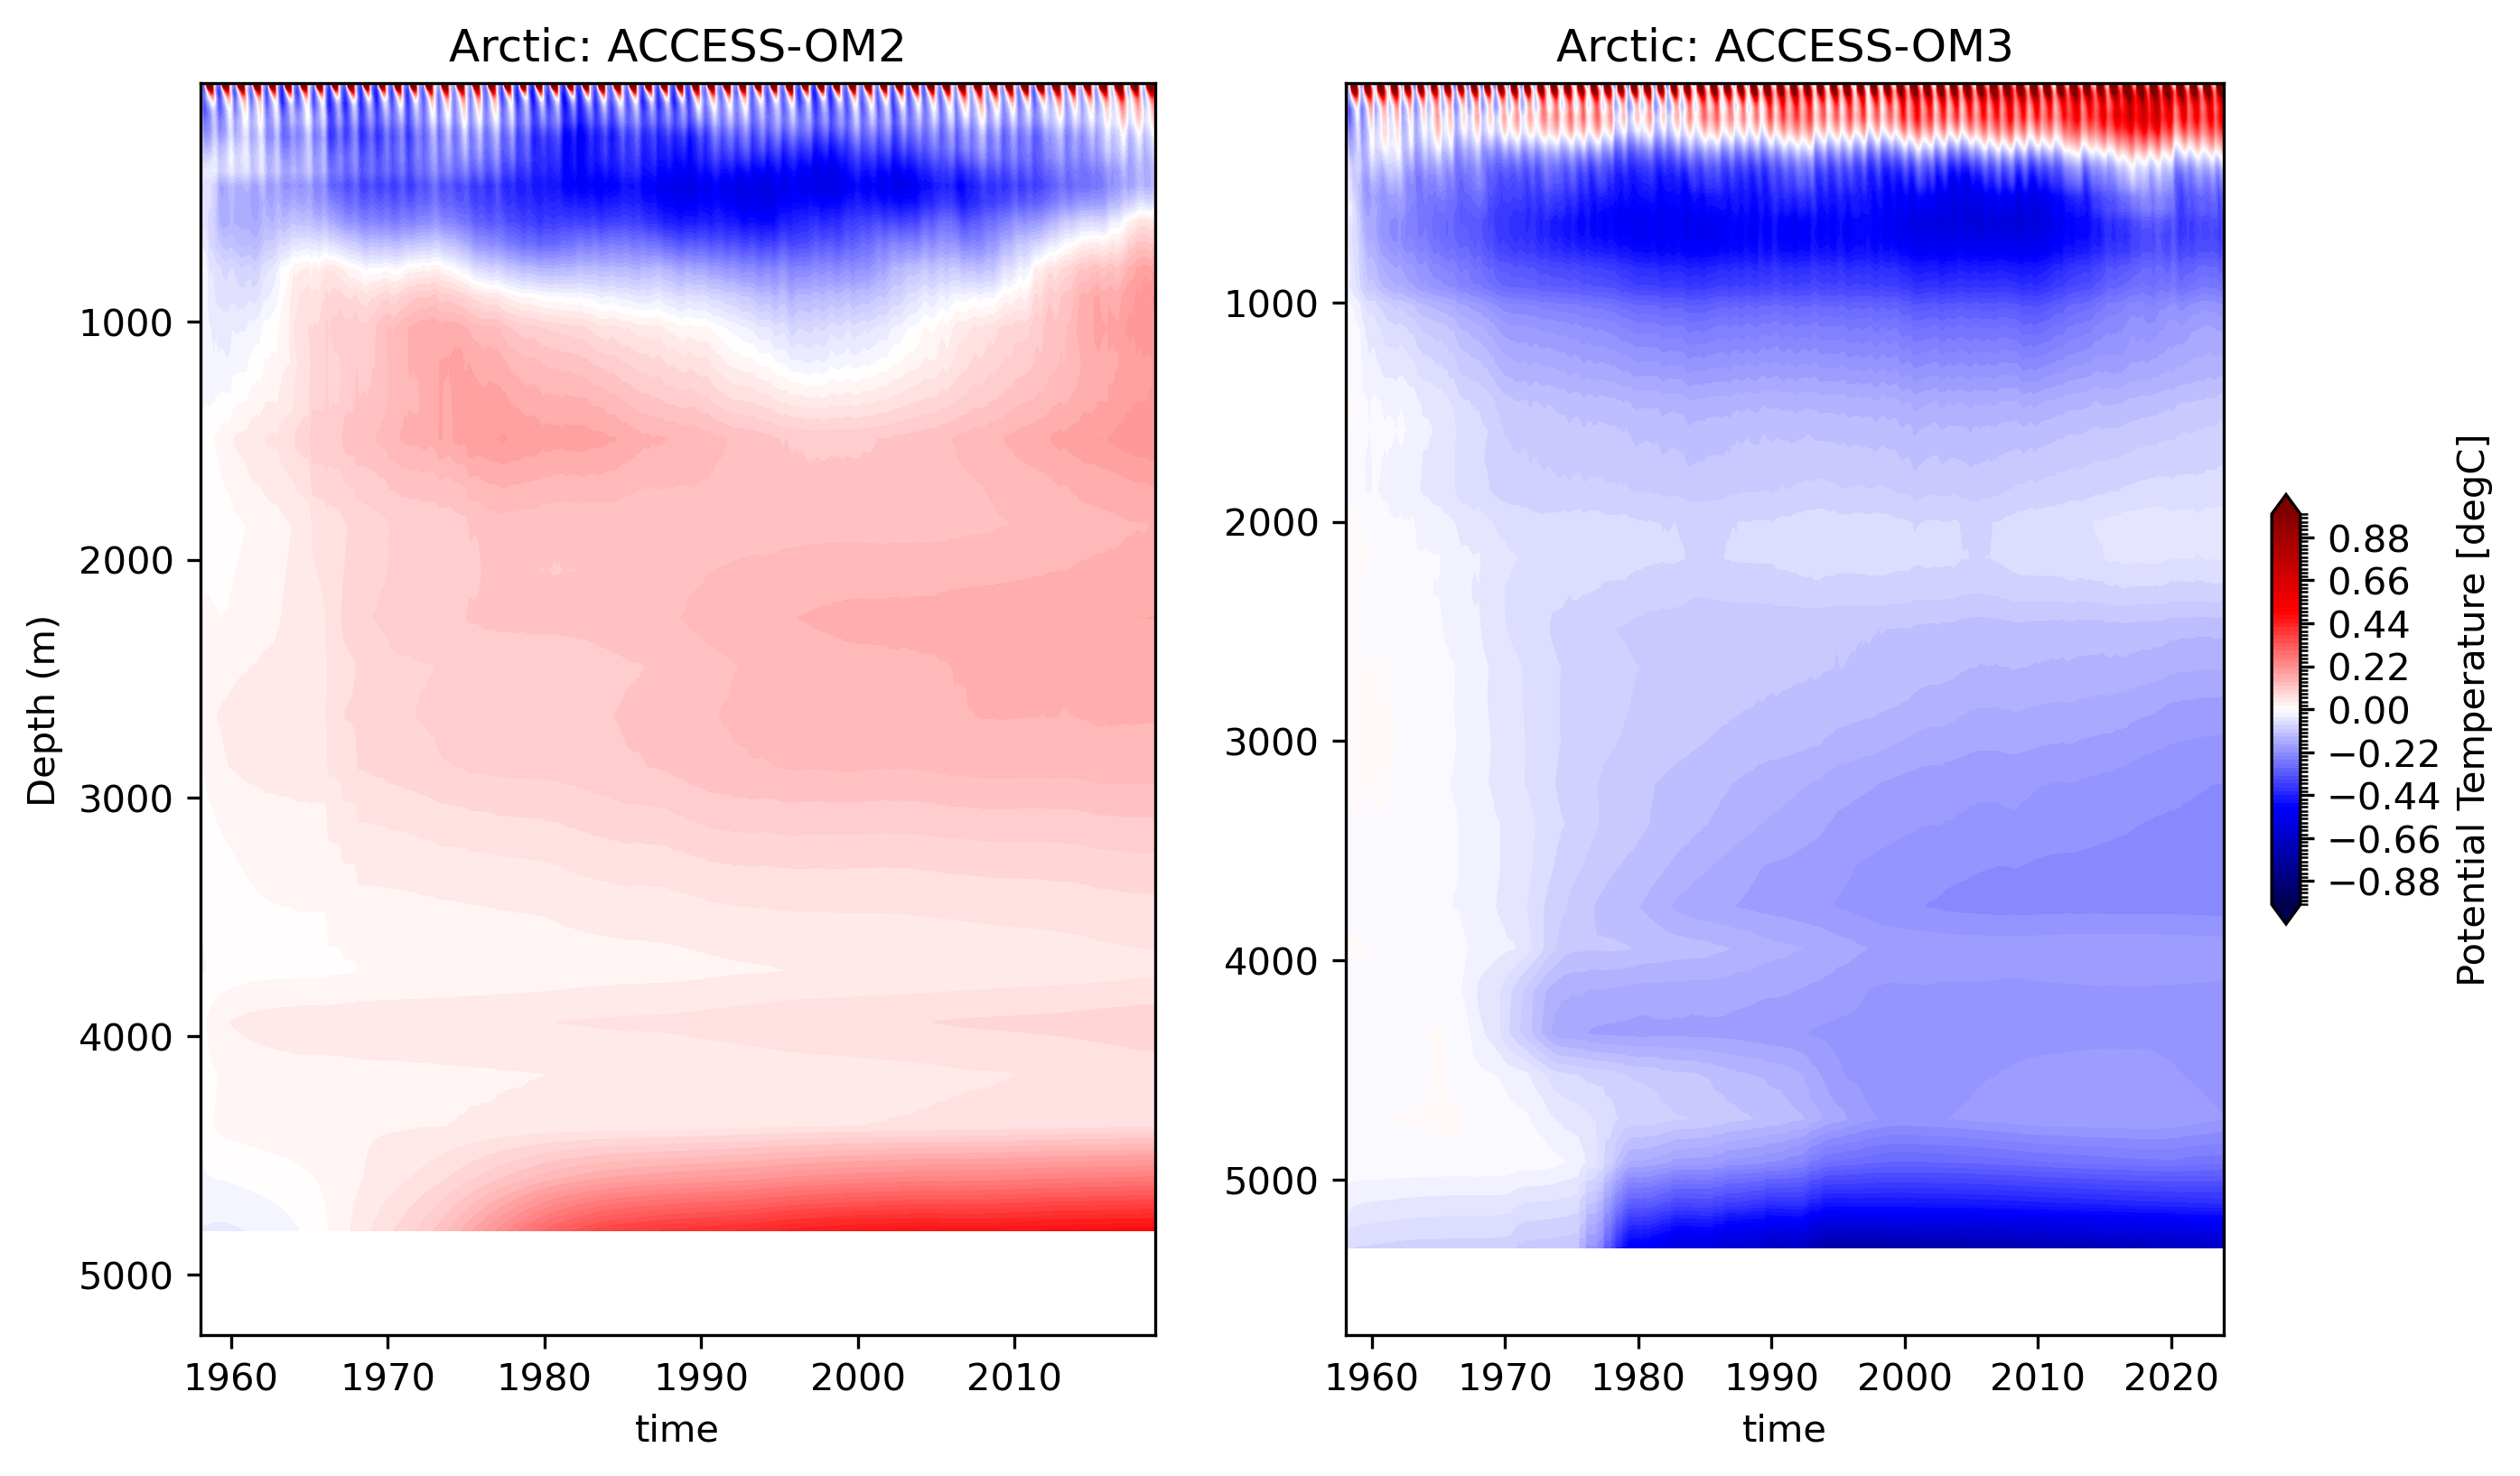

In [45]:
plt.figure(figsize=(10,6))

plt.subplot(121)
(om2model-om2model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    # extend="both",
    cmap='seismic',
    add_colorbar=False,
    #cbar_kwargs={"label": "\n".join(wrap(f"{om2model.attrs['long_name']} [{om2model.attrs['units']}]", 45)),
    #             "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.gca().invert_yaxis()
#plt.title("\n".join(wrap(f"UNWEIGHTED Horizontal mean {om2model.attrs['long_name']} drift from initial condition in {om2exptname}", 60)))
plt.title('Arctic: ACCESS-OM2')
plt.ylabel('Depth (m)')

plt.subplot(122)
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    # extend="both",
    extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.ylabel('')
plt.gca().invert_yaxis()
#plt.title("\n".join(wrap(f"UNWEIGHTED Horizontal mean {model.attrs['long_name']} drift from initial condition in {exptname}", 60)))
plt.title('Arctic: ACCESS-OM3')

# Southern Ocean

In [41]:
om2model = om2model_all.sel(xt_ocean=slice(so[0],so[1])).sel(yt_ocean=slice(so[2],so[3])).mean('yt_ocean').mean('xt_ocean').load()
model = model_all.sel(xh=slice(so[0],so[1])).sel(yh=slice(so[2],so[3])).mean('yh').mean('xh').load()

Text(0.5, 1.0, 'Southern Ocean: ACCESS-OM3')

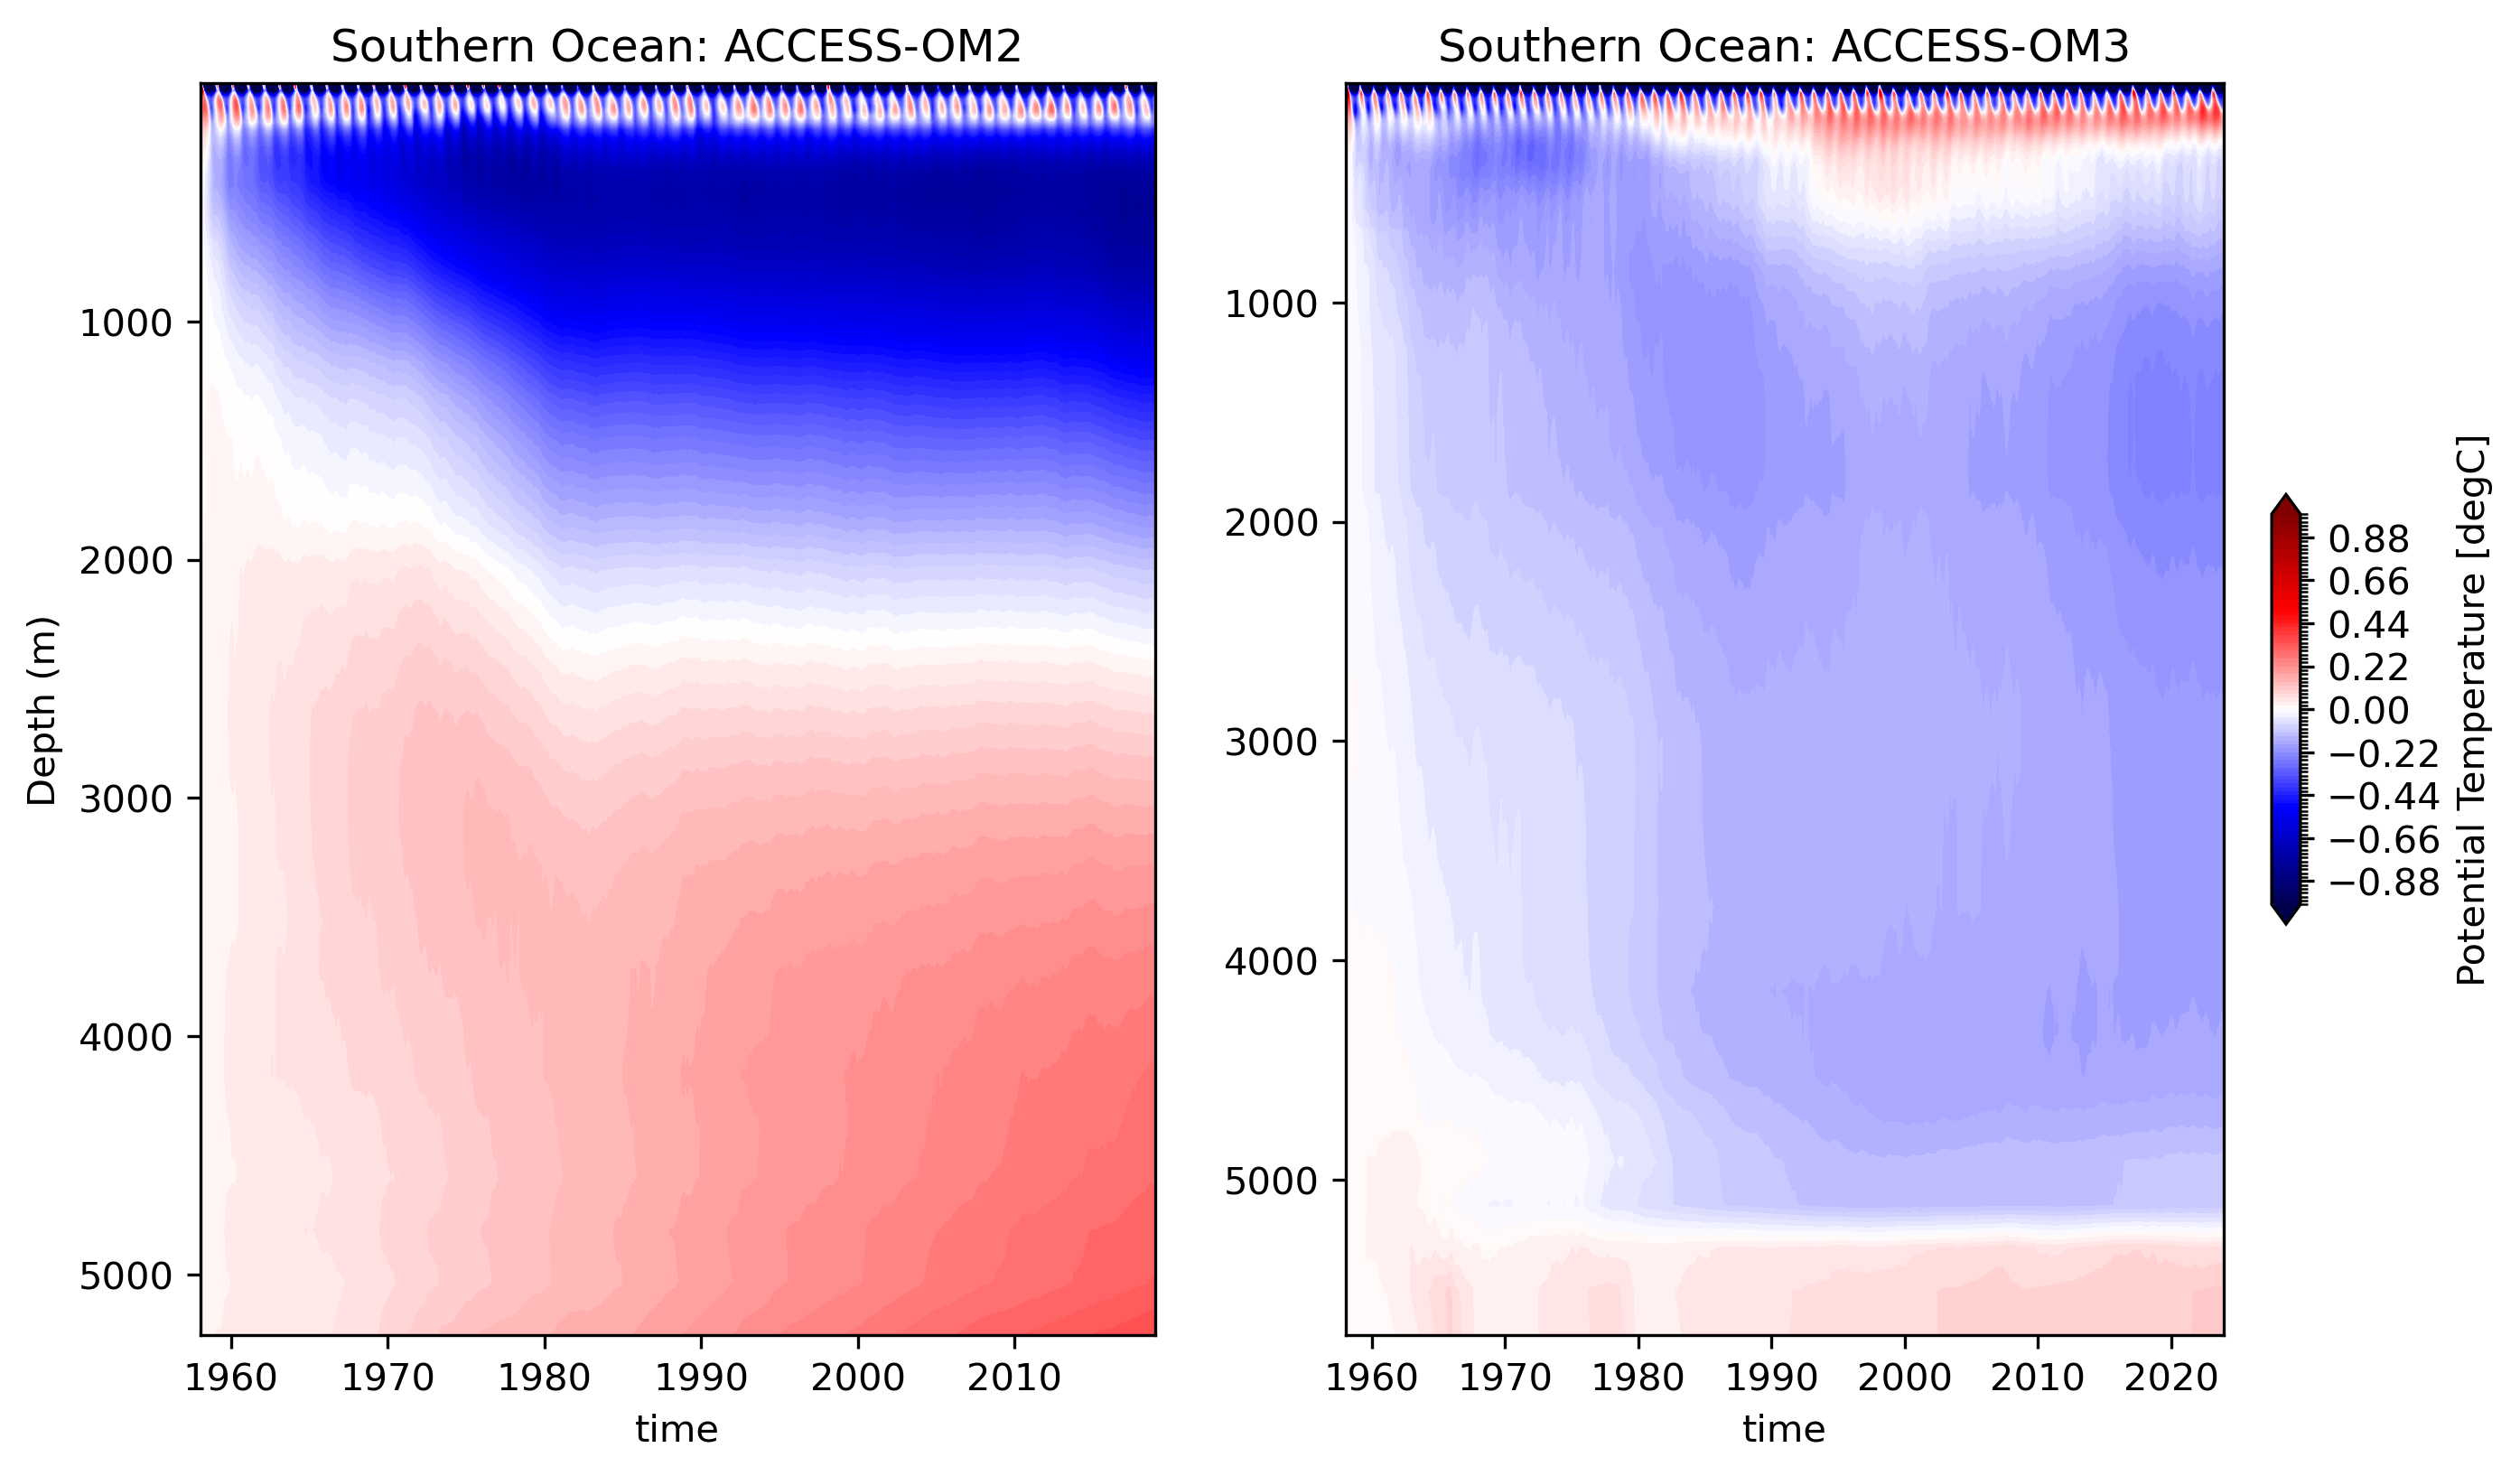

In [42]:
plt.figure(figsize=(10,6))

plt.subplot(121)
(om2model-om2model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    cmap='seismic',
    add_colorbar=False,
)
plt.gca().invert_yaxis()
plt.title('Southern Ocean: ACCESS-OM2')
plt.ylabel('Depth (m)')

plt.subplot(122)
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.ylabel('')
plt.gca().invert_yaxis()
plt.title('Southern Ocean: ACCESS-OM3')

# ACC

In [46]:
om2model = om2model_all.sel(xt_ocean=slice(acc[0],acc[1])).sel(yt_ocean=slice(acc[2],acc[3])).mean('yt_ocean').mean('xt_ocean').load()
model = model_all.sel(xh=slice(acc[0],acc[1])).sel(yh=slice(acc[2],acc[3])).mean('yh').mean('xh').load()

Text(0.5, 1.0, 'ACC: ACCESS-OM3')

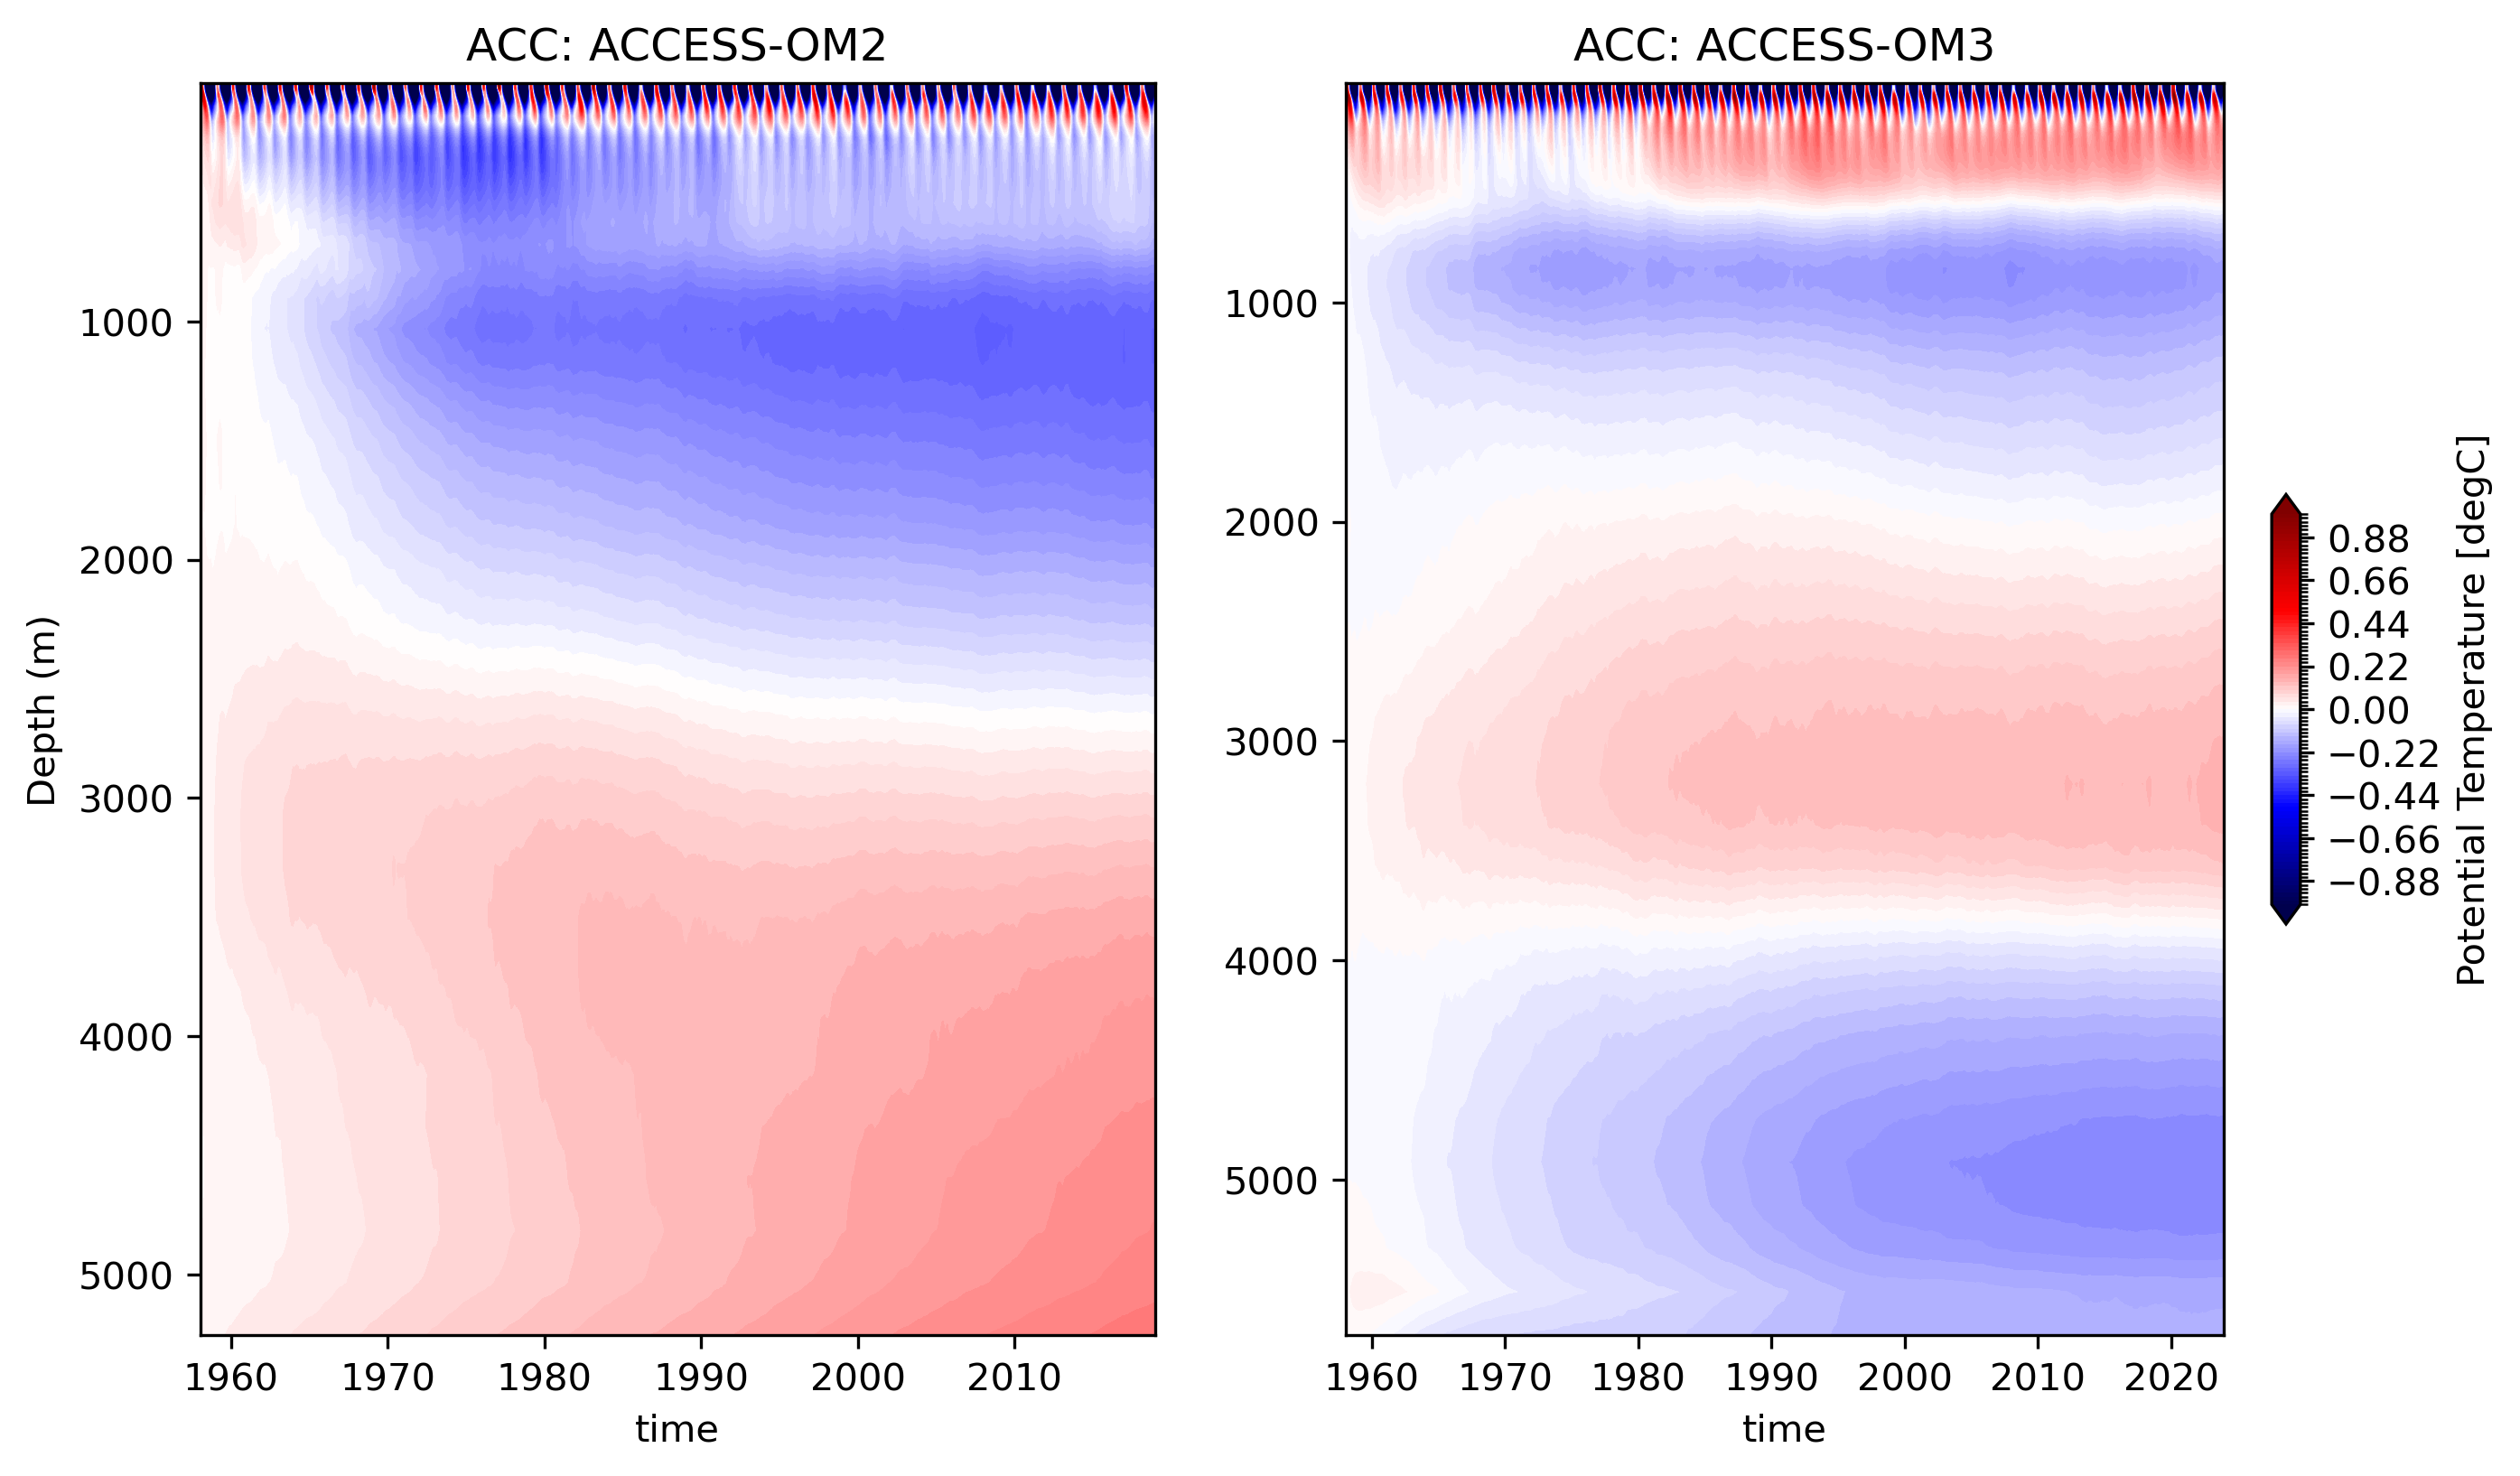

In [47]:
plt.figure(figsize=(10,6))

plt.subplot(121)
(om2model-om2model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    cmap='seismic',
    add_colorbar=False,
)
plt.gca().invert_yaxis()
plt.title('ACC: ACCESS-OM2')
plt.ylabel('Depth (m)')

plt.subplot(122)
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.ylabel('')
plt.gca().invert_yaxis()
plt.title('ACC: ACCESS-OM3')

# South Pacific

In [49]:
om2model = om2model_all.sel(xt_ocean=slice(spac[0],spac[1])).sel(yt_ocean=slice(spac[2],spac[3])).mean('yt_ocean').mean('xt_ocean').load()
model = model_all.sel(xh=slice(spac[0],spac[1])).sel(yh=slice(spac[2],spac[3])).mean('yh').mean('xh').load()

Text(0.5, 1.0, 'South Pacific: ACCESS-OM3')

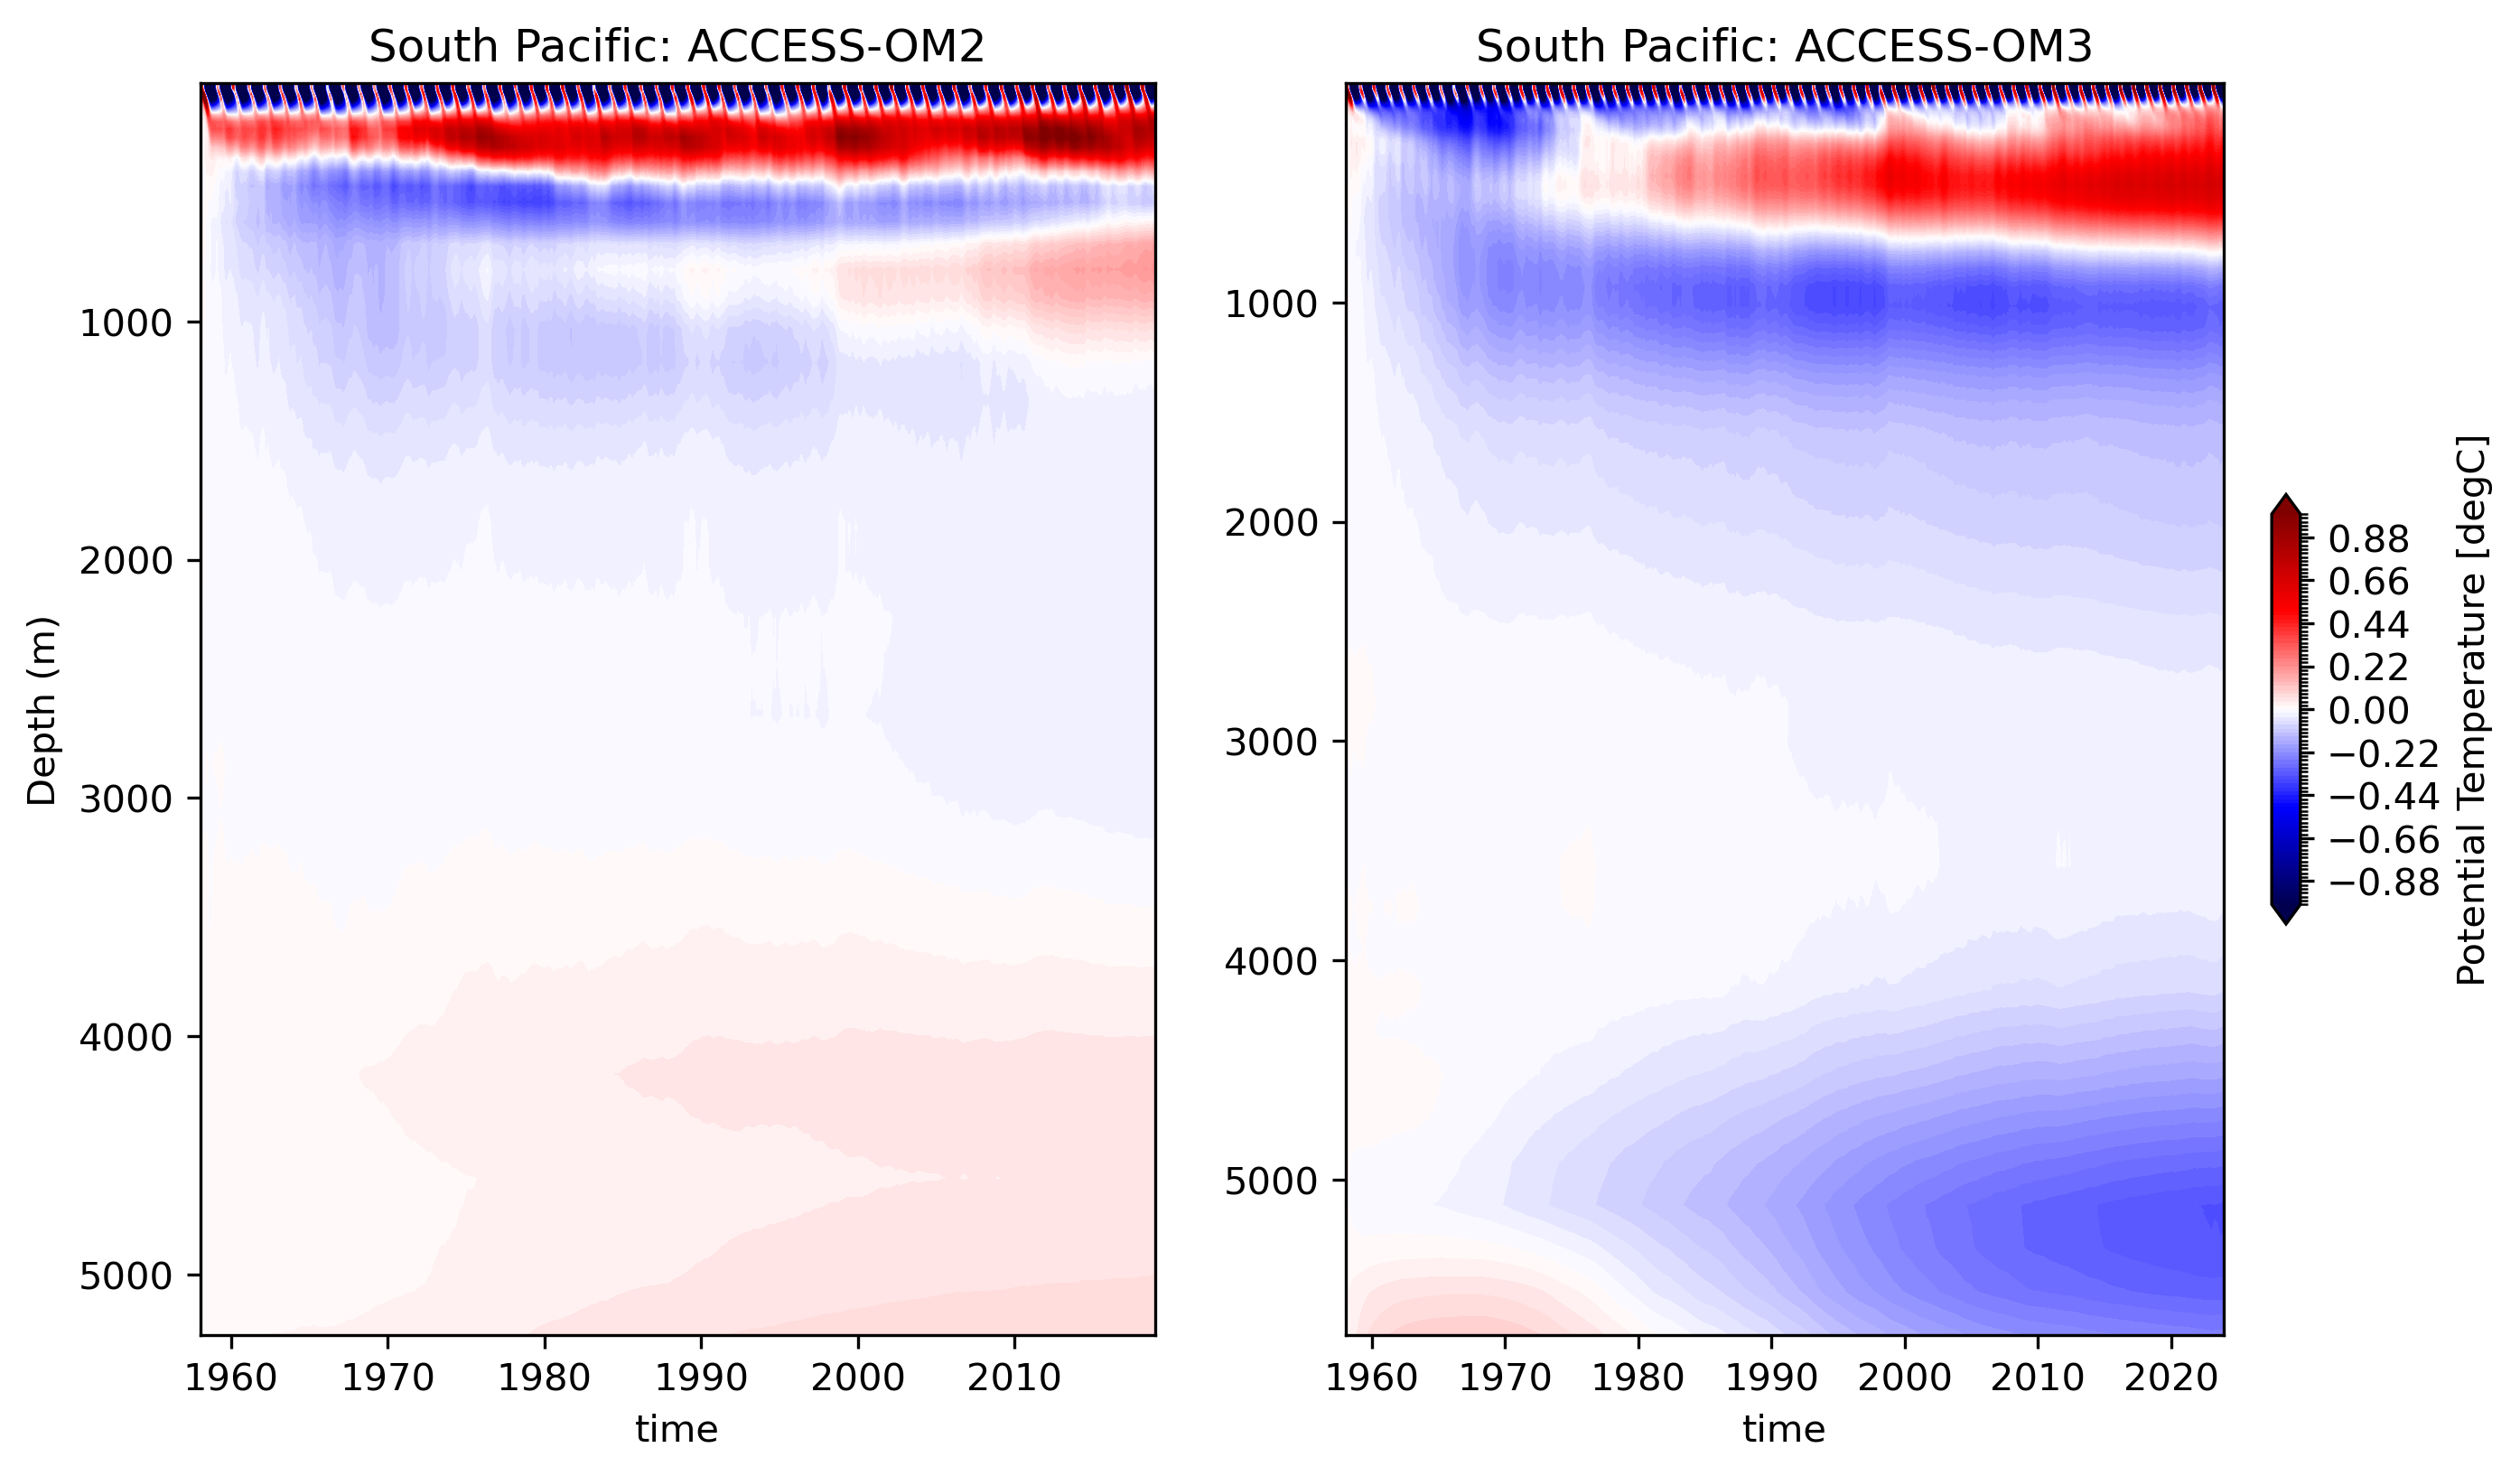

In [50]:
plt.figure(figsize=(10,6))

plt.subplot(121)
(om2model-om2model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    cmap='seismic',
    add_colorbar=False,
)
plt.gca().invert_yaxis()
plt.title('South Pacific: ACCESS-OM2')
plt.ylabel('Depth (m)')

plt.subplot(122)
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.ylabel('')
plt.gca().invert_yaxis()
plt.title('South Pacific: ACCESS-OM3')

# Tropical Pacific

In [52]:
om2model = om2model_all.sel(xt_ocean=slice(tpac[0],tpac[1])).sel(yt_ocean=slice(tpac[2],tpac[3])).mean('yt_ocean').mean('xt_ocean').load()
model = model_all.sel(xh=slice(tpac[0],tpac[1])).sel(yh=slice(tpac[2],tpac[3])).mean('yh').mean('xh').load()

Text(0.5, 1.0, 'Tropical Pacific: ACCESS-OM3')

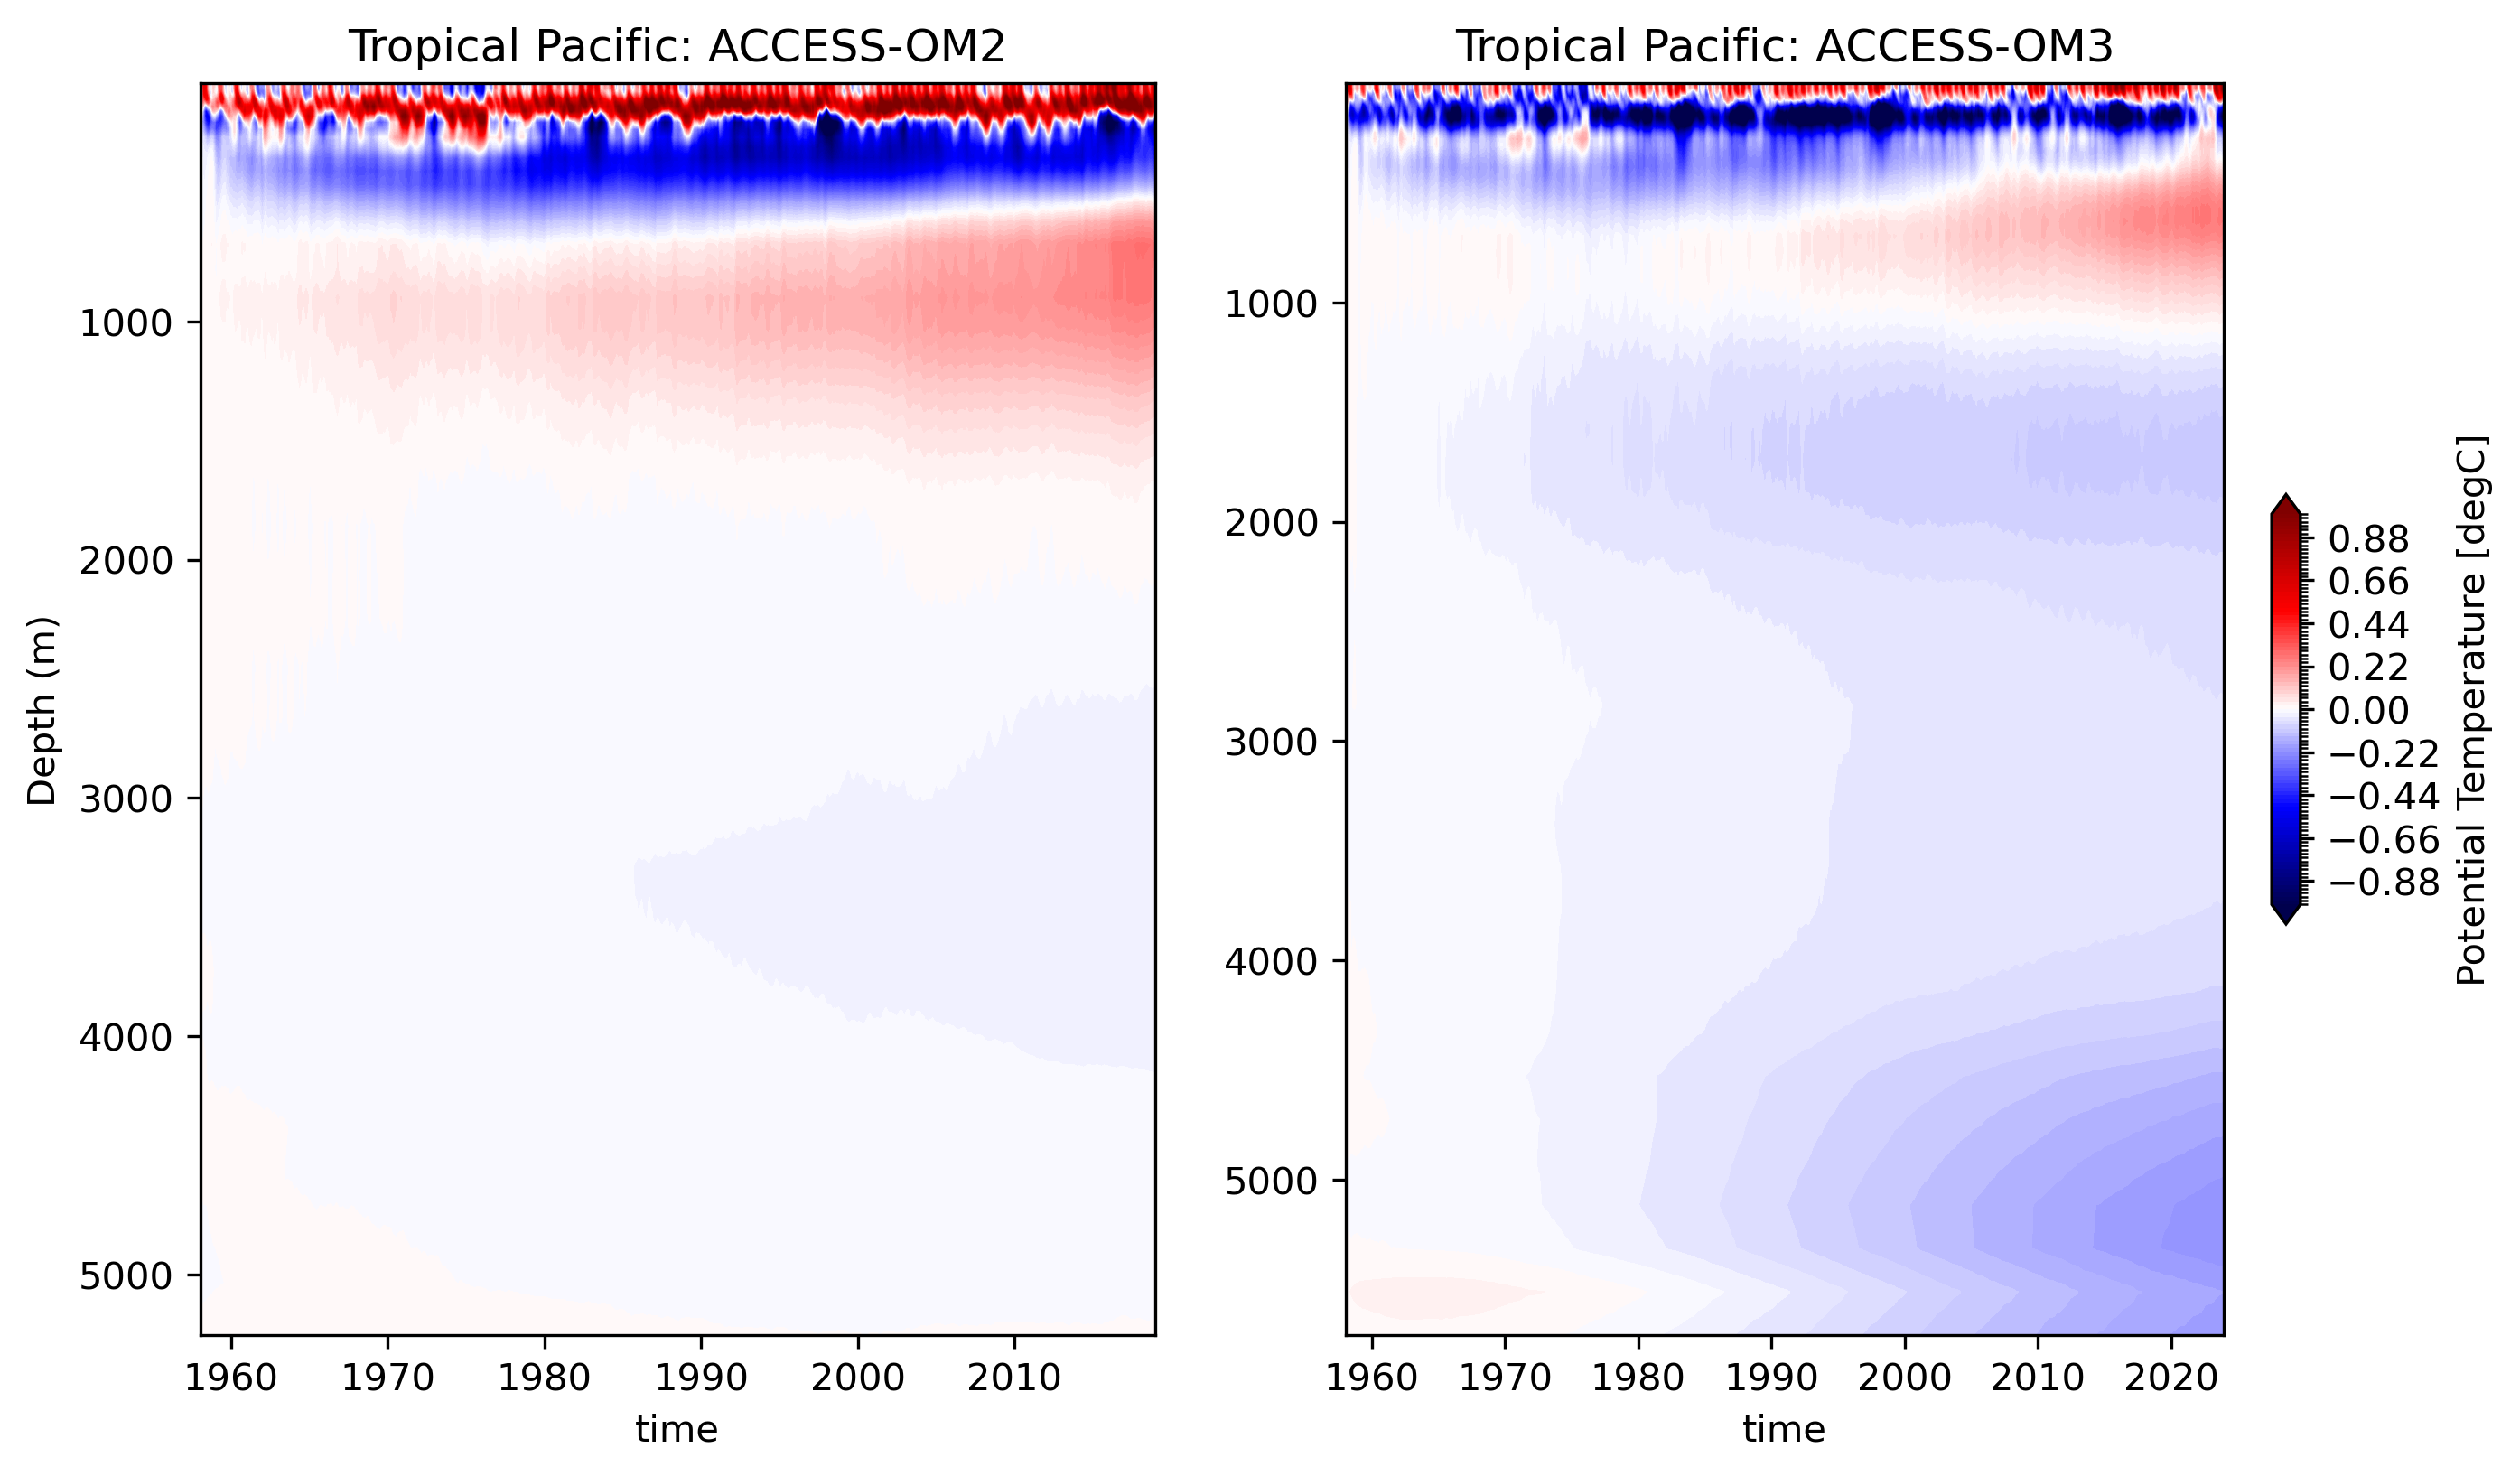

In [53]:
plt.figure(figsize=(10,6))

plt.subplot(121)
(om2model-om2model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    cmap='seismic',
    add_colorbar=False,
)
plt.gca().invert_yaxis()
plt.title('Tropical Pacific: ACCESS-OM2')
plt.ylabel('Depth (m)')

plt.subplot(122)
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.ylabel('')
plt.gca().invert_yaxis()
plt.title('Tropical Pacific: ACCESS-OM3')

# North Pacific

In [55]:
om2model = om2model_all.sel(xt_ocean=slice(npac[0],npac[1])).sel(yt_ocean=slice(npac[2],npac[3])).mean('yt_ocean').mean('xt_ocean').load()
model = model_all.sel(xh=slice(npac[0],npac[1])).sel(yh=slice(npac[2],npac[3])).mean('yh').mean('xh').load()

Text(0.5, 1.0, 'North Pacific: ACCESS-OM3')

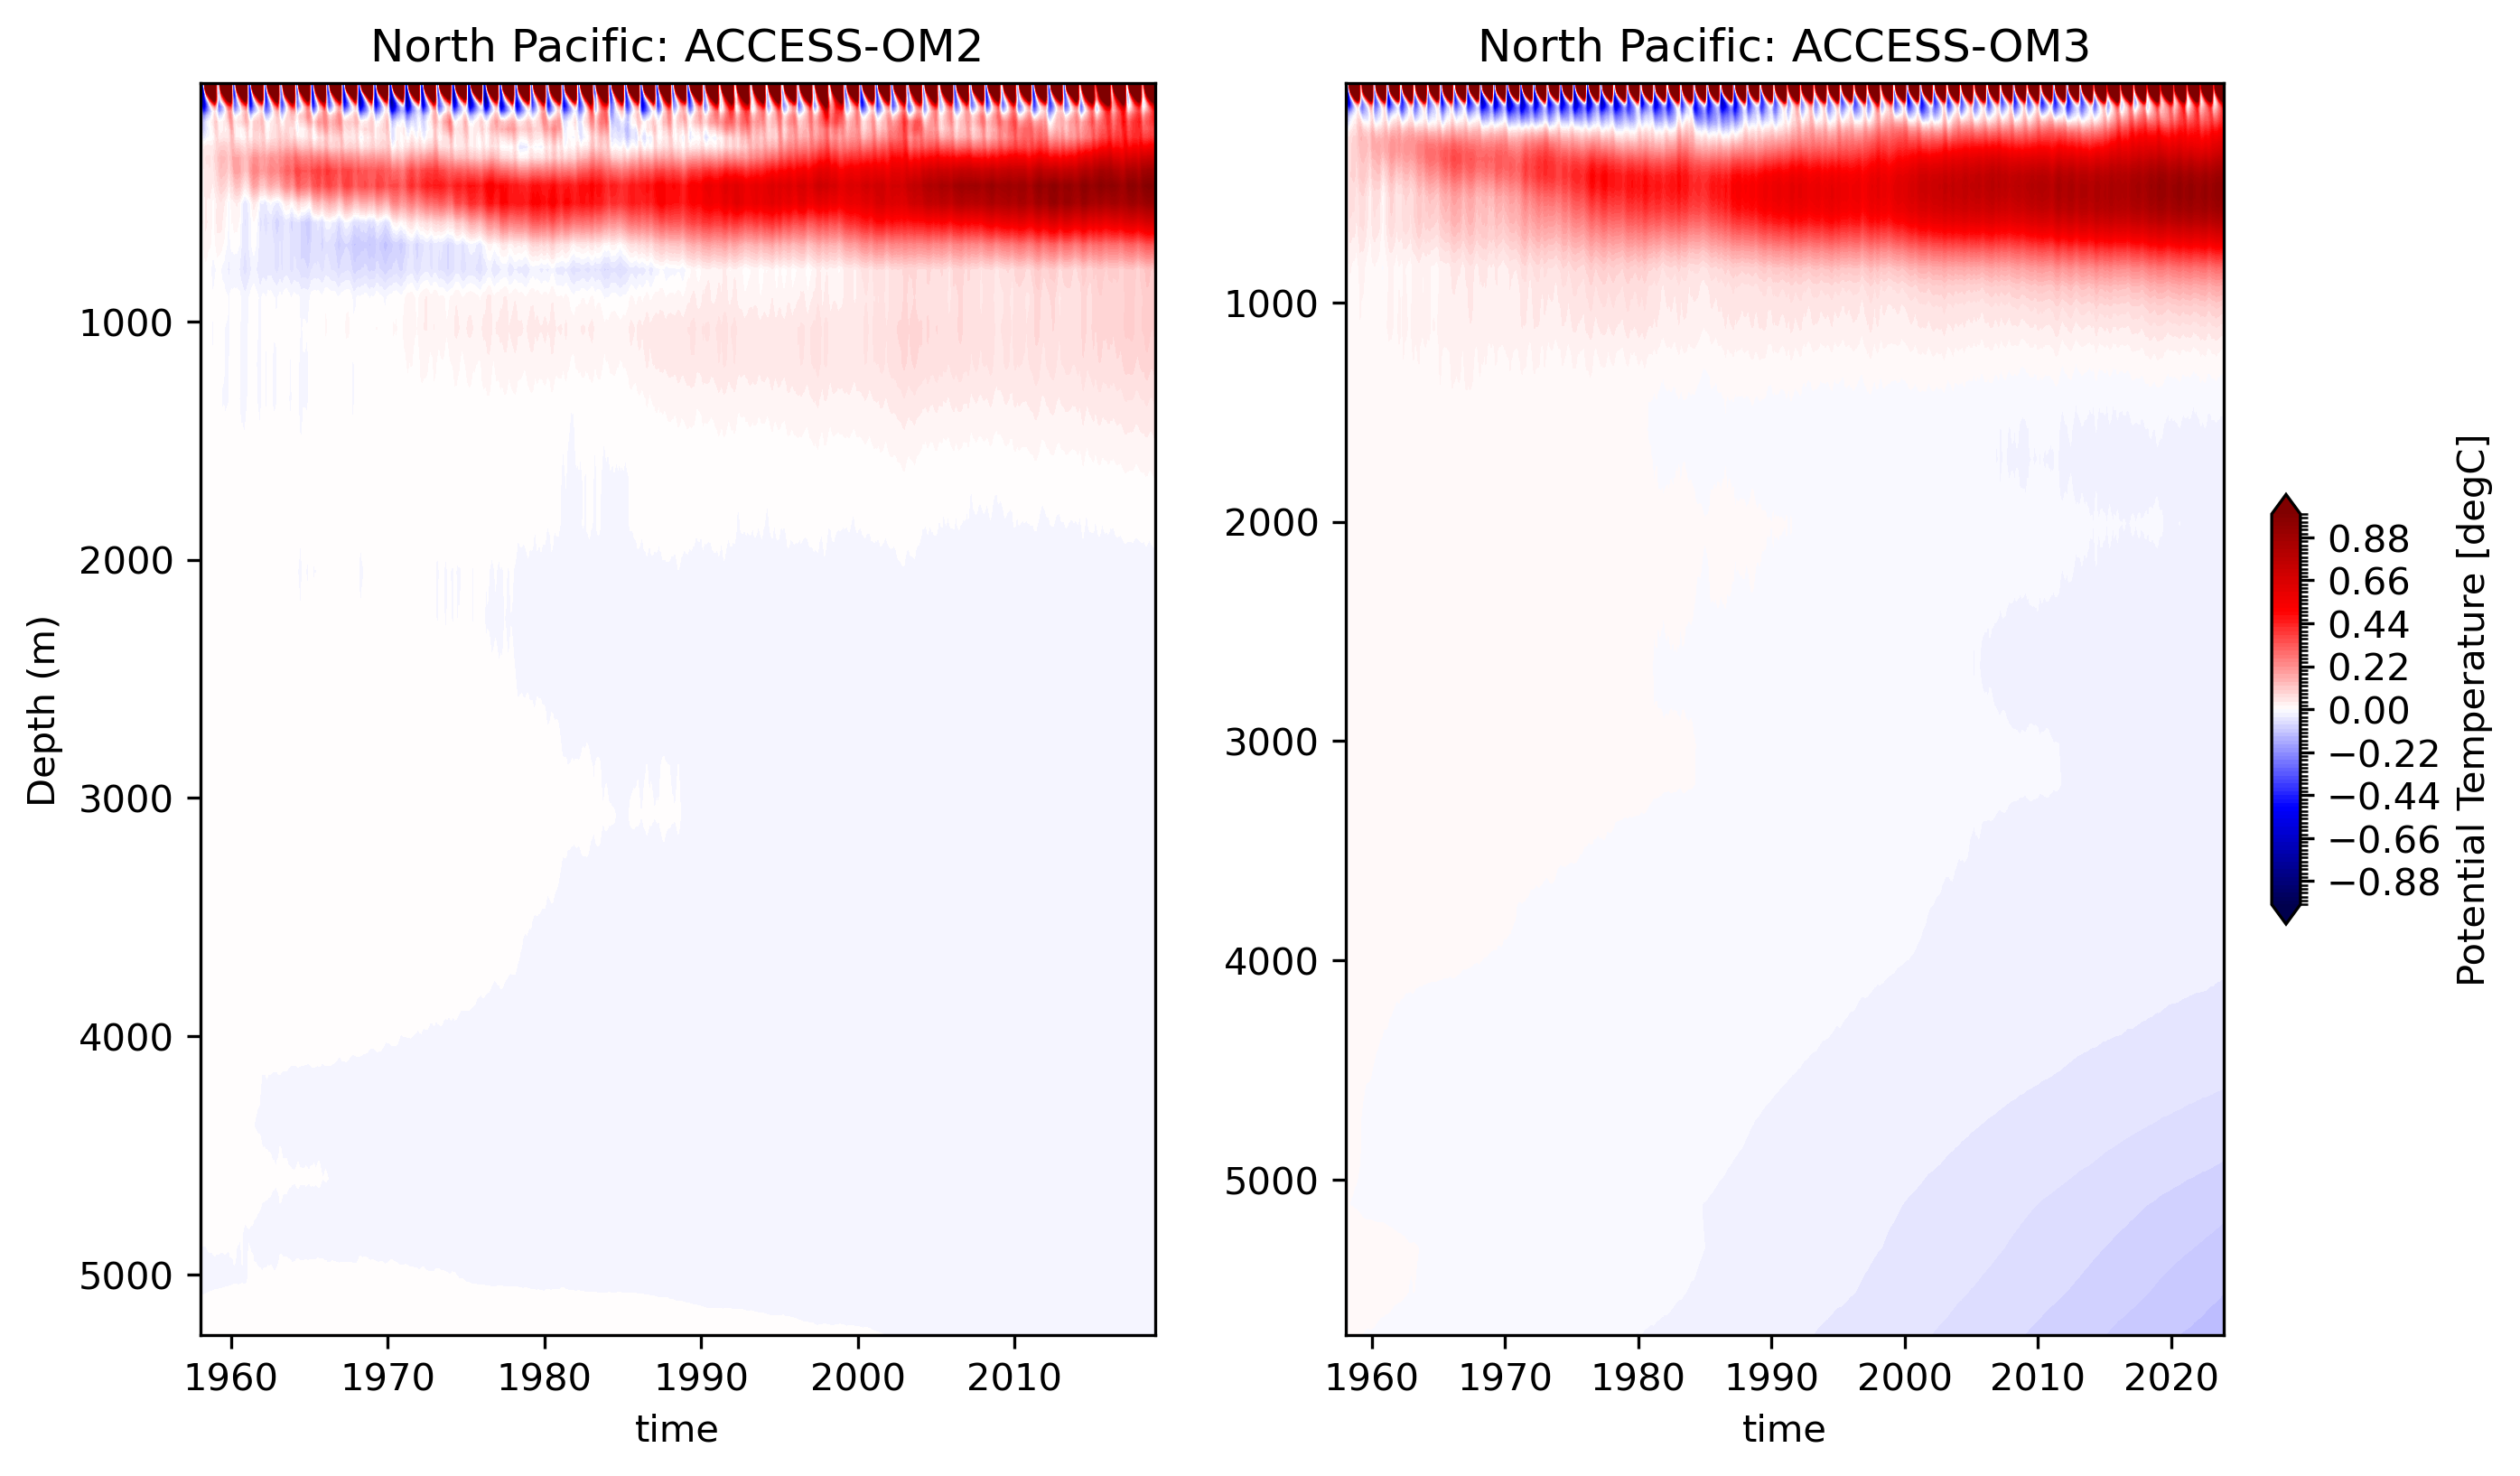

In [56]:
plt.figure(figsize=(10,6))

plt.subplot(121)
(om2model-om2model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    cmap='seismic',
    add_colorbar=False,
)
plt.gca().invert_yaxis()
plt.title('North Pacific: ACCESS-OM2')
plt.ylabel('Depth (m)')

plt.subplot(122)
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.ylabel('')
plt.gca().invert_yaxis()
plt.title('North Pacific: ACCESS-OM3')

# South Atlantic

In [59]:
om2model = om2model_all.sel(xt_ocean=slice(satl[0],satl[1])).sel(yt_ocean=slice(satl[2],satl[3])).mean('yt_ocean').mean('xt_ocean').load()
model = model_all.sel(xh=slice(satl[0],satl[1])).sel(yh=slice(satl[2],satl[3])).mean('yh').mean('xh').load()

Text(0.5, 1.0, 'South Atlantic: ACCESS-OM3')

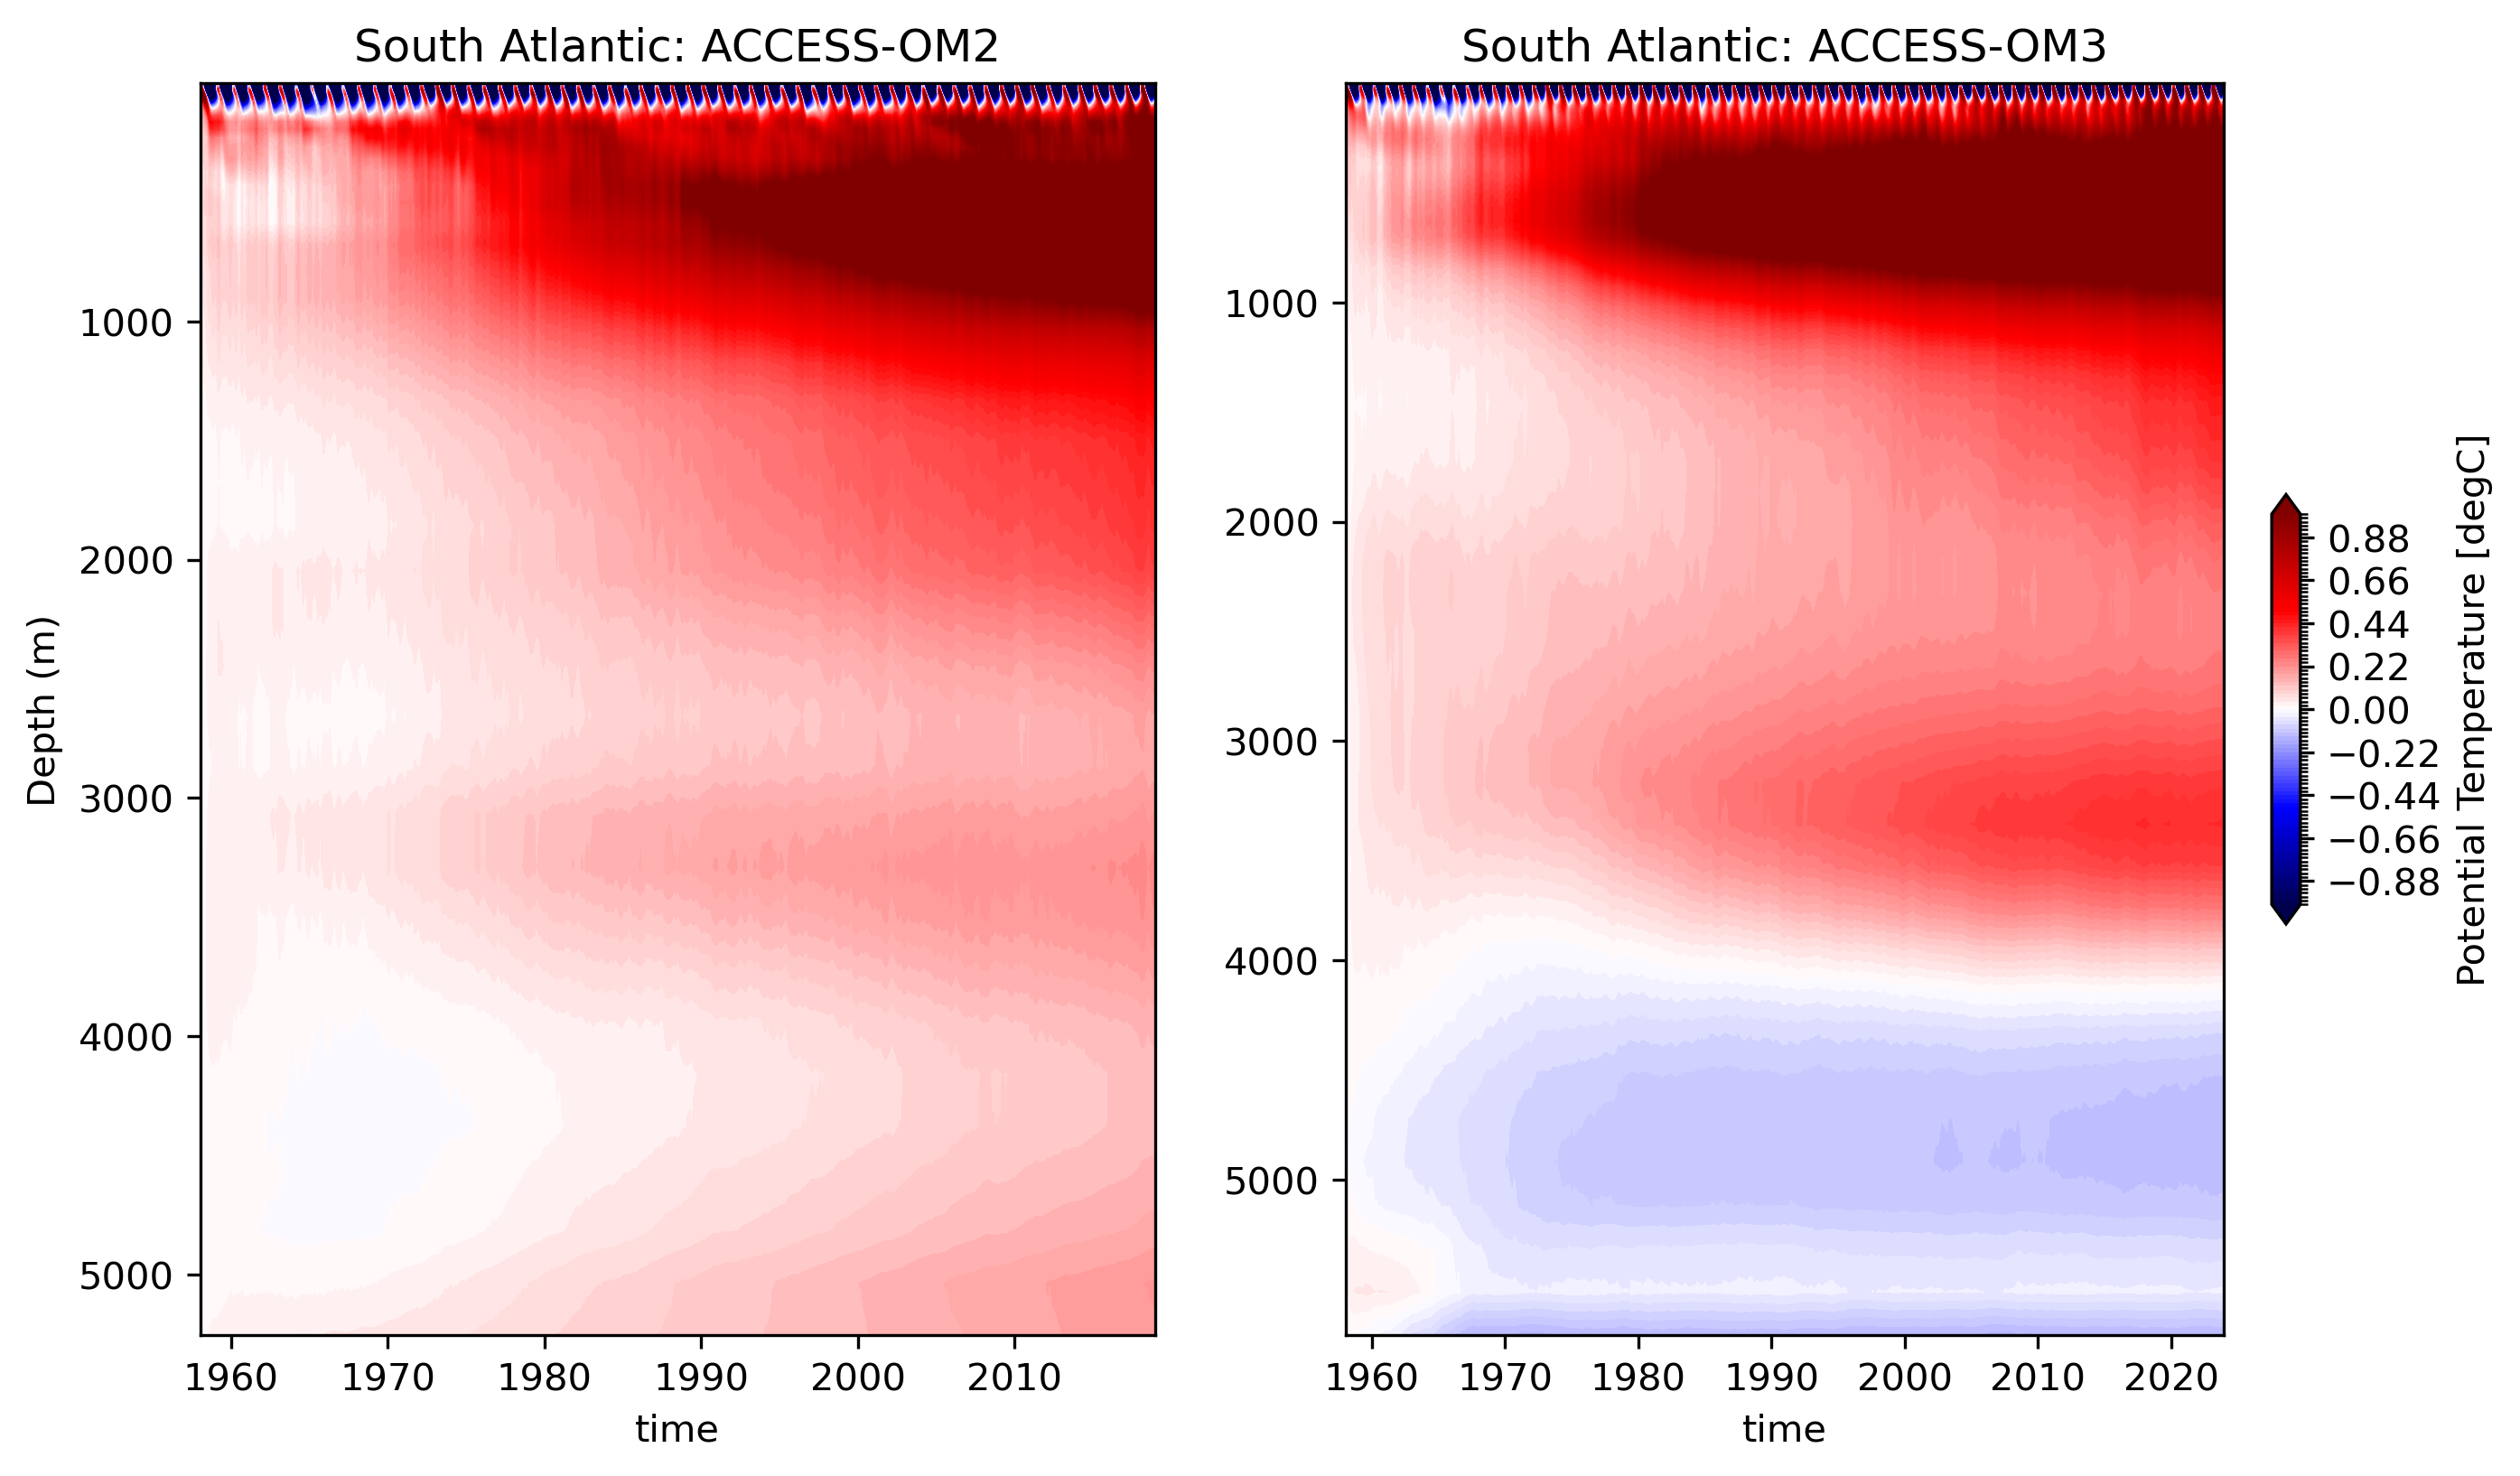

In [60]:
plt.figure(figsize=(10,6))

plt.subplot(121)
(om2model-om2model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    cmap='seismic',
    add_colorbar=False,
)
plt.gca().invert_yaxis()
plt.title('South Atlantic: ACCESS-OM2')
plt.ylabel('Depth (m)')

plt.subplot(122)
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.ylabel('')
plt.gca().invert_yaxis()
plt.title('South Atlantic: ACCESS-OM3')

# Tropical Atlantic

In [62]:
om2model = om2model_all.sel(xt_ocean=slice(tatl[0],tatl[1])).sel(yt_ocean=slice(tatl[2],tatl[3])).mean('yt_ocean').mean('xt_ocean').load()
model = model_all.sel(xh=slice(tatl[0],tatl[1])).sel(yh=slice(tatl[2],tatl[3])).mean('yh').mean('xh').load()

Text(0.5, 1.0, 'Tropical Atlantic: ACCESS-OM3')

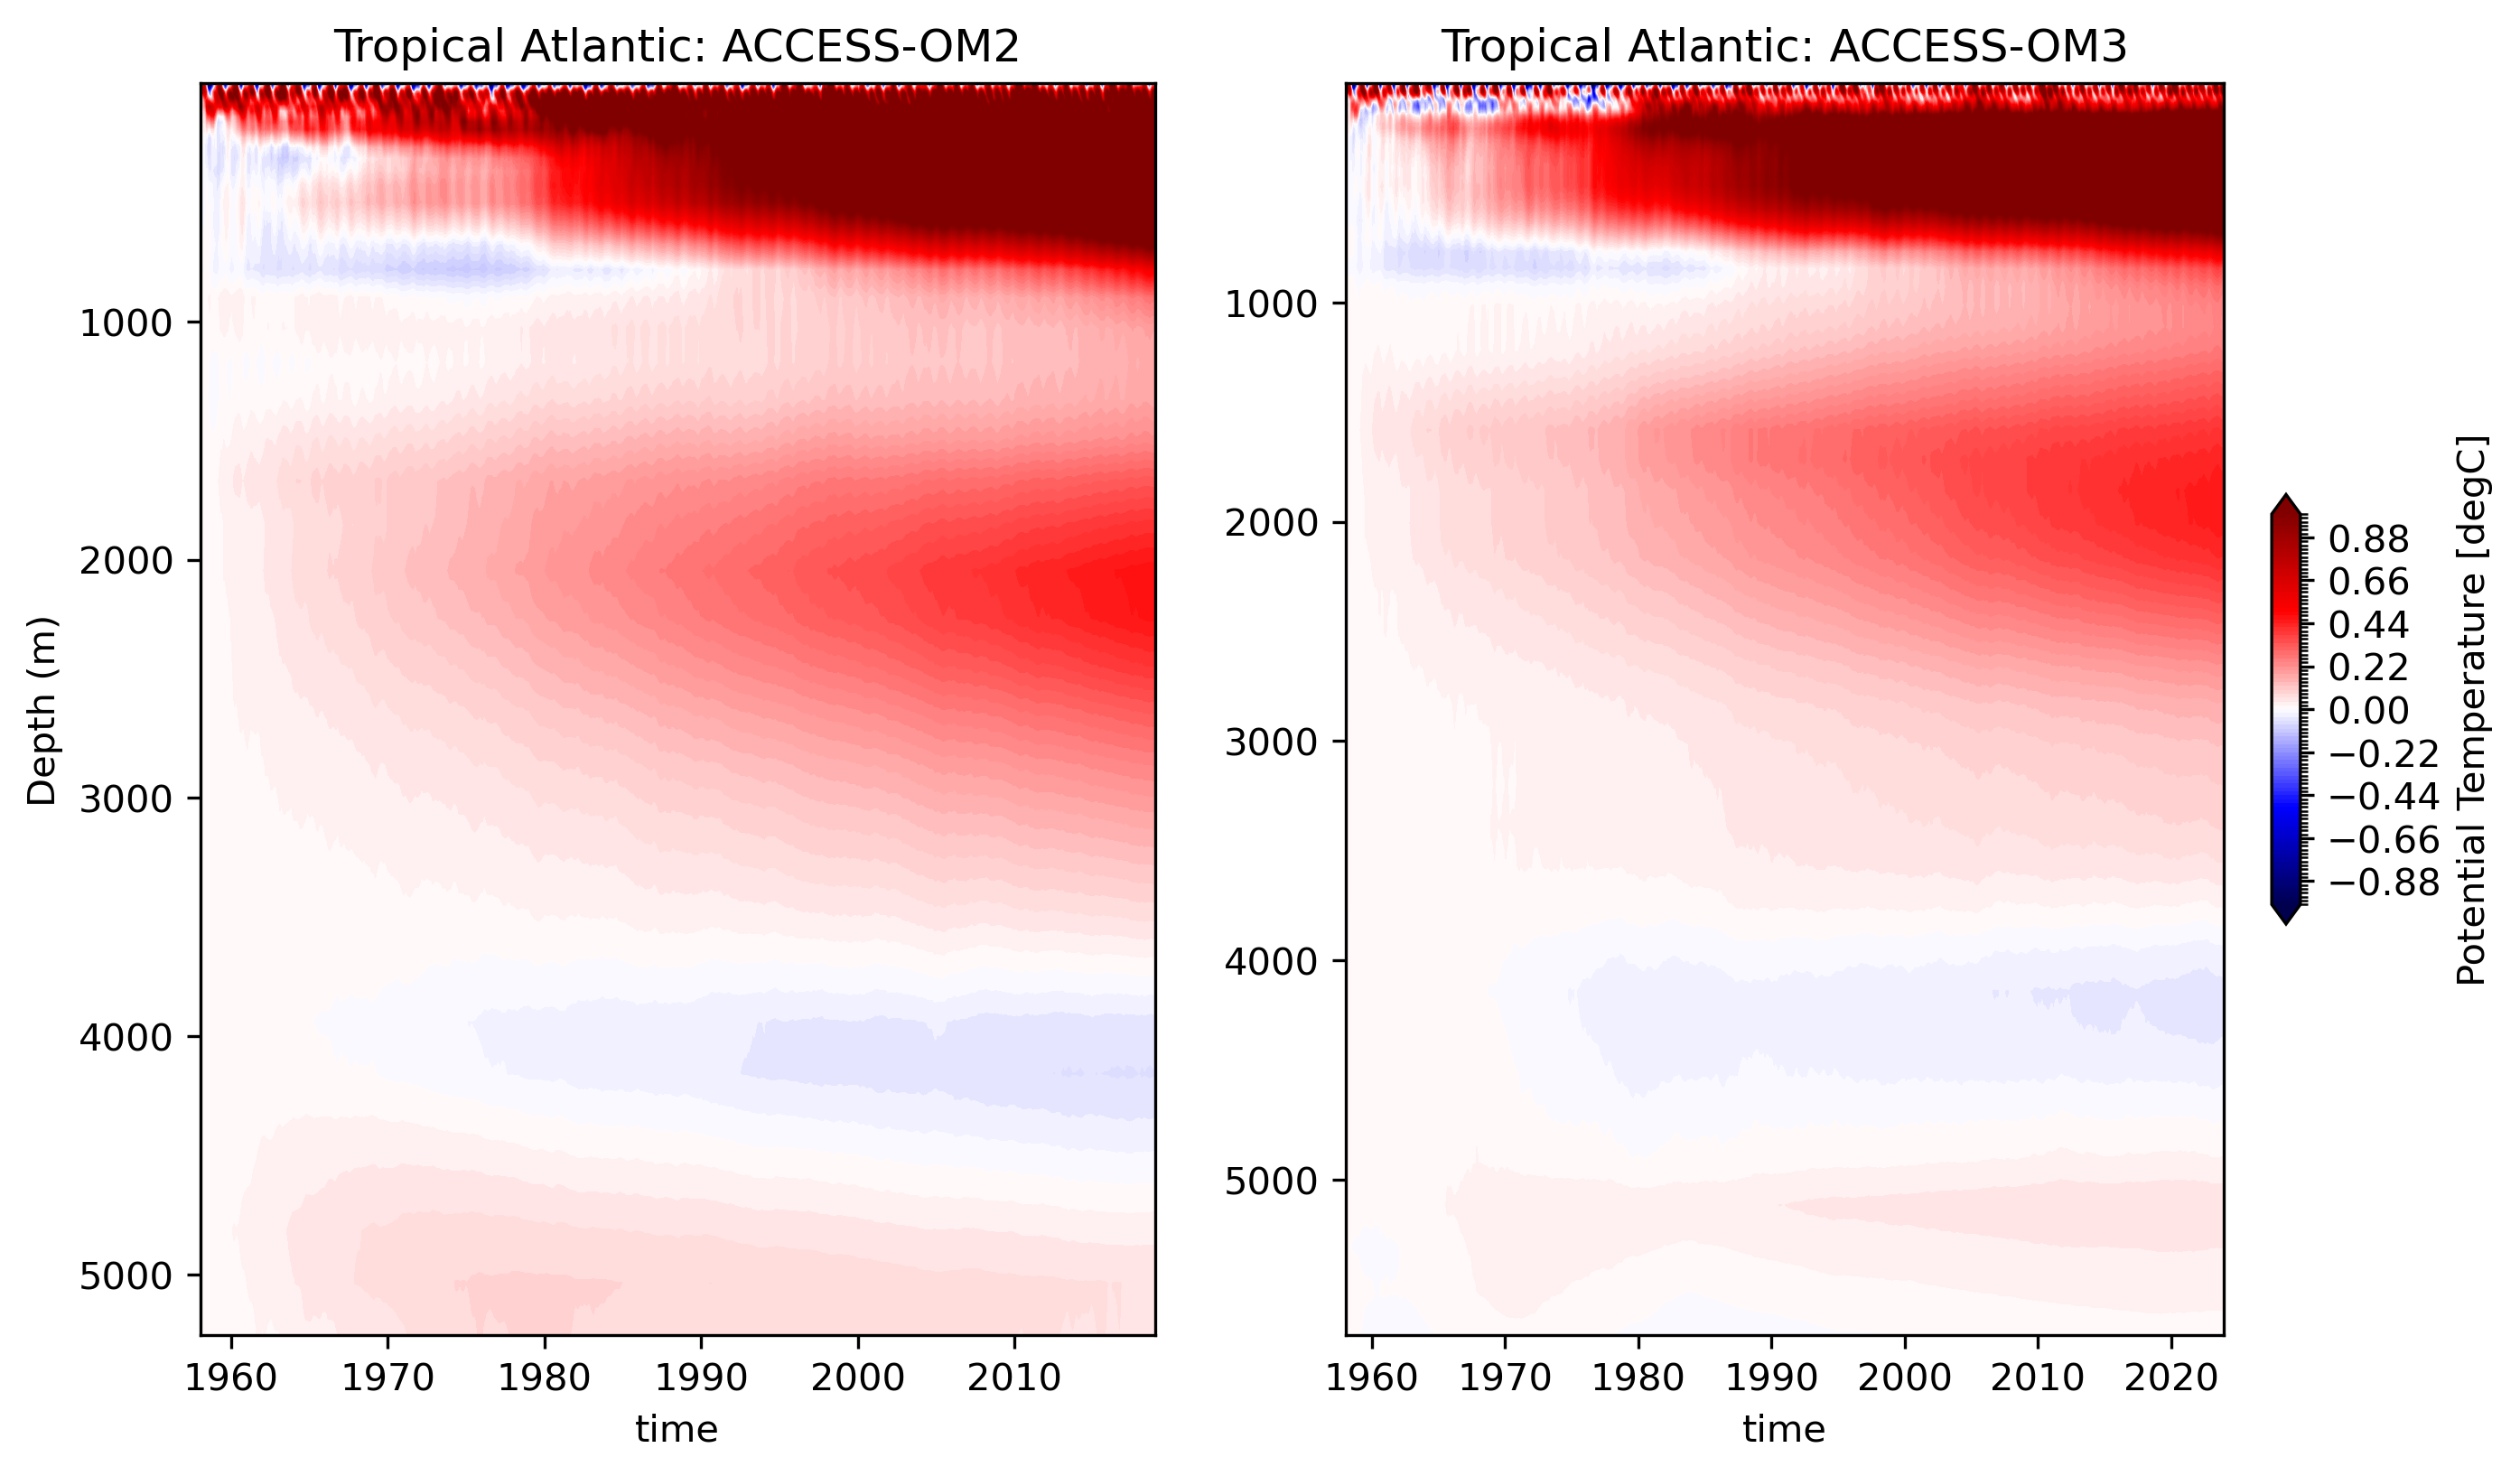

In [63]:
plt.figure(figsize=(10,6))

plt.subplot(121)
(om2model-om2model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    cmap='seismic',
    add_colorbar=False,
)
plt.gca().invert_yaxis()
plt.title('Tropical Atlantic: ACCESS-OM2')
plt.ylabel('Depth (m)')

plt.subplot(122)
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.ylabel('')
plt.gca().invert_yaxis()
plt.title('Tropical Atlantic: ACCESS-OM3')

# North Atlantic

In [72]:
om2model = om2model_all.sel(xt_ocean=slice(natl[0],natl[1])).sel(yt_ocean=slice(natl[2],natl[3])).mean('yt_ocean').mean('xt_ocean').load()
model = model_all.sel(xh=slice(natl[0],natl[1])).sel(yh=slice(natl[2],natl[3])).mean('yh').mean('xh').load()

Text(0.5, 1.0, 'North Atlantic: ACCESS-OM3')

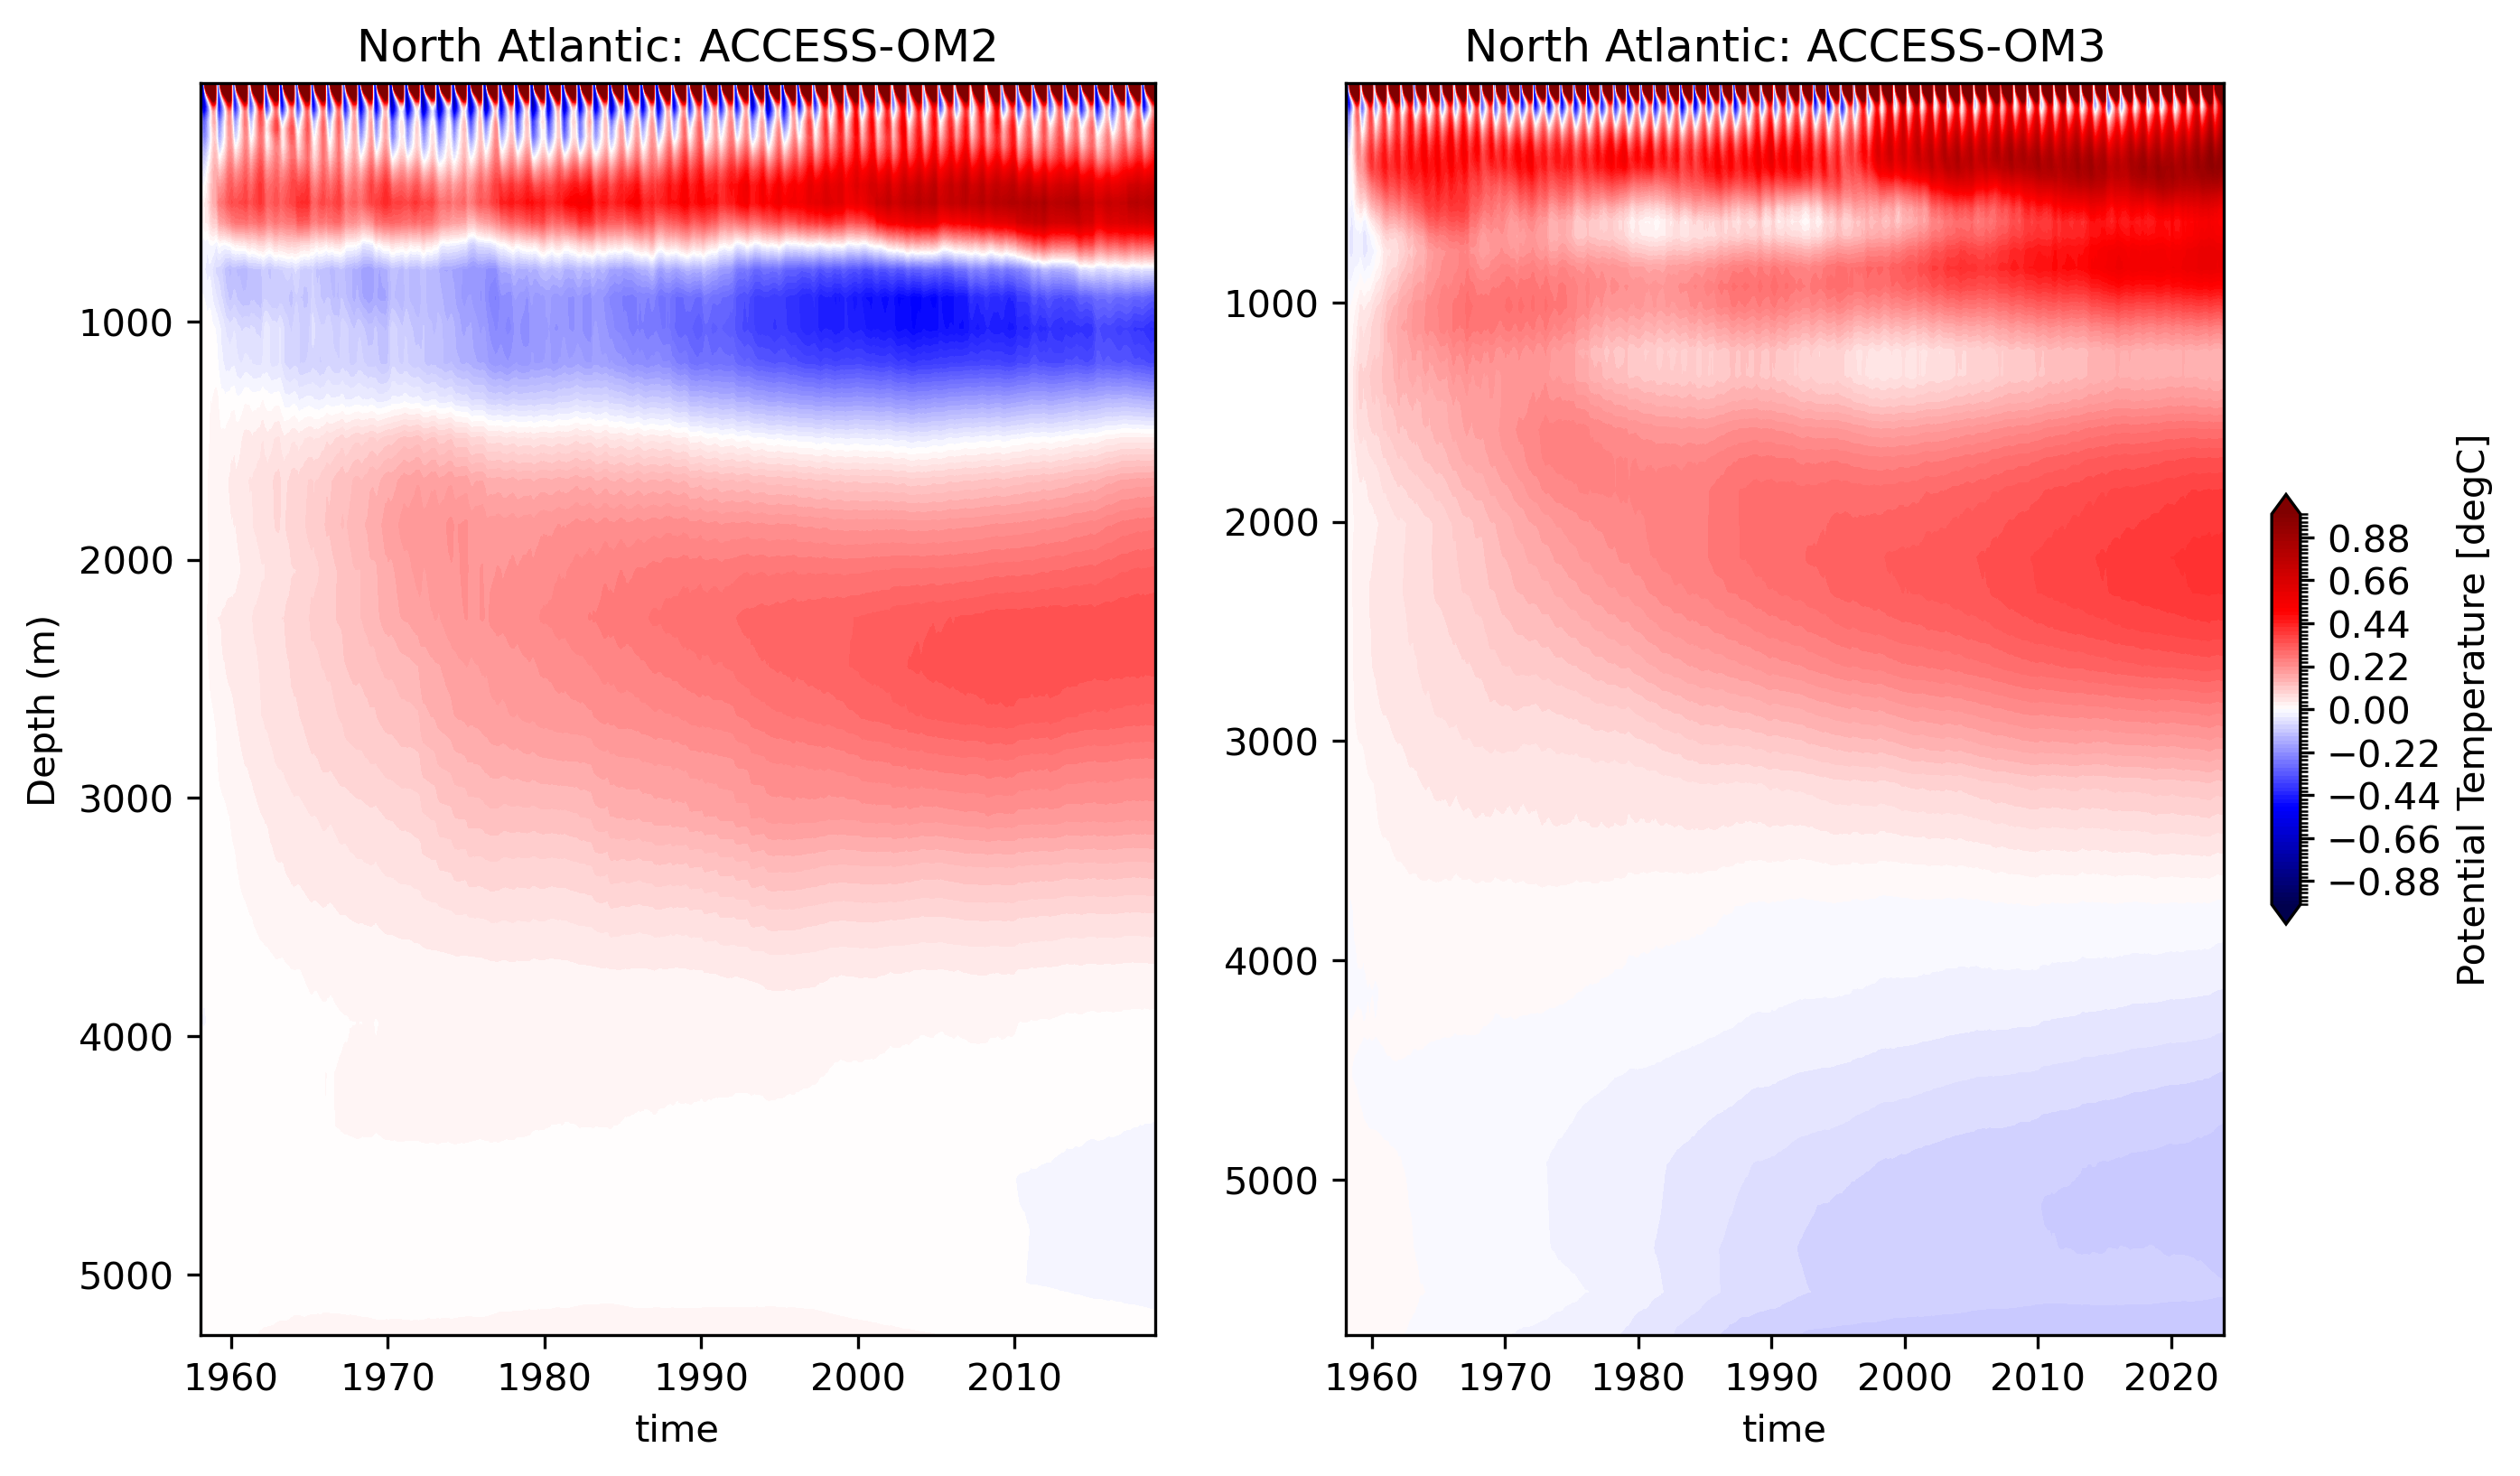

In [73]:
plt.figure(figsize=(10,6))

plt.subplot(121)
(om2model-om2model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    cmap='seismic',
    add_colorbar=False,
)
plt.gca().invert_yaxis()
plt.title('North Atlantic: ACCESS-OM2')
plt.ylabel('Depth (m)')

plt.subplot(122)
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.ylabel('')
plt.gca().invert_yaxis()
plt.title('North Atlantic: ACCESS-OM3')

# Indian

In [68]:
om2model = om2model_all.sel(xt_ocean=slice(ind[0],ind[1])).sel(yt_ocean=slice(ind[2],ind[3])).mean('yt_ocean').mean('xt_ocean').load()
model = model_all.sel(xh=slice(ind[0],ind[1])).sel(yh=slice(ind[2],ind[3])).mean('yh').mean('xh').load()

Text(0.5, 1.0, 'Indian: ACCESS-OM3')

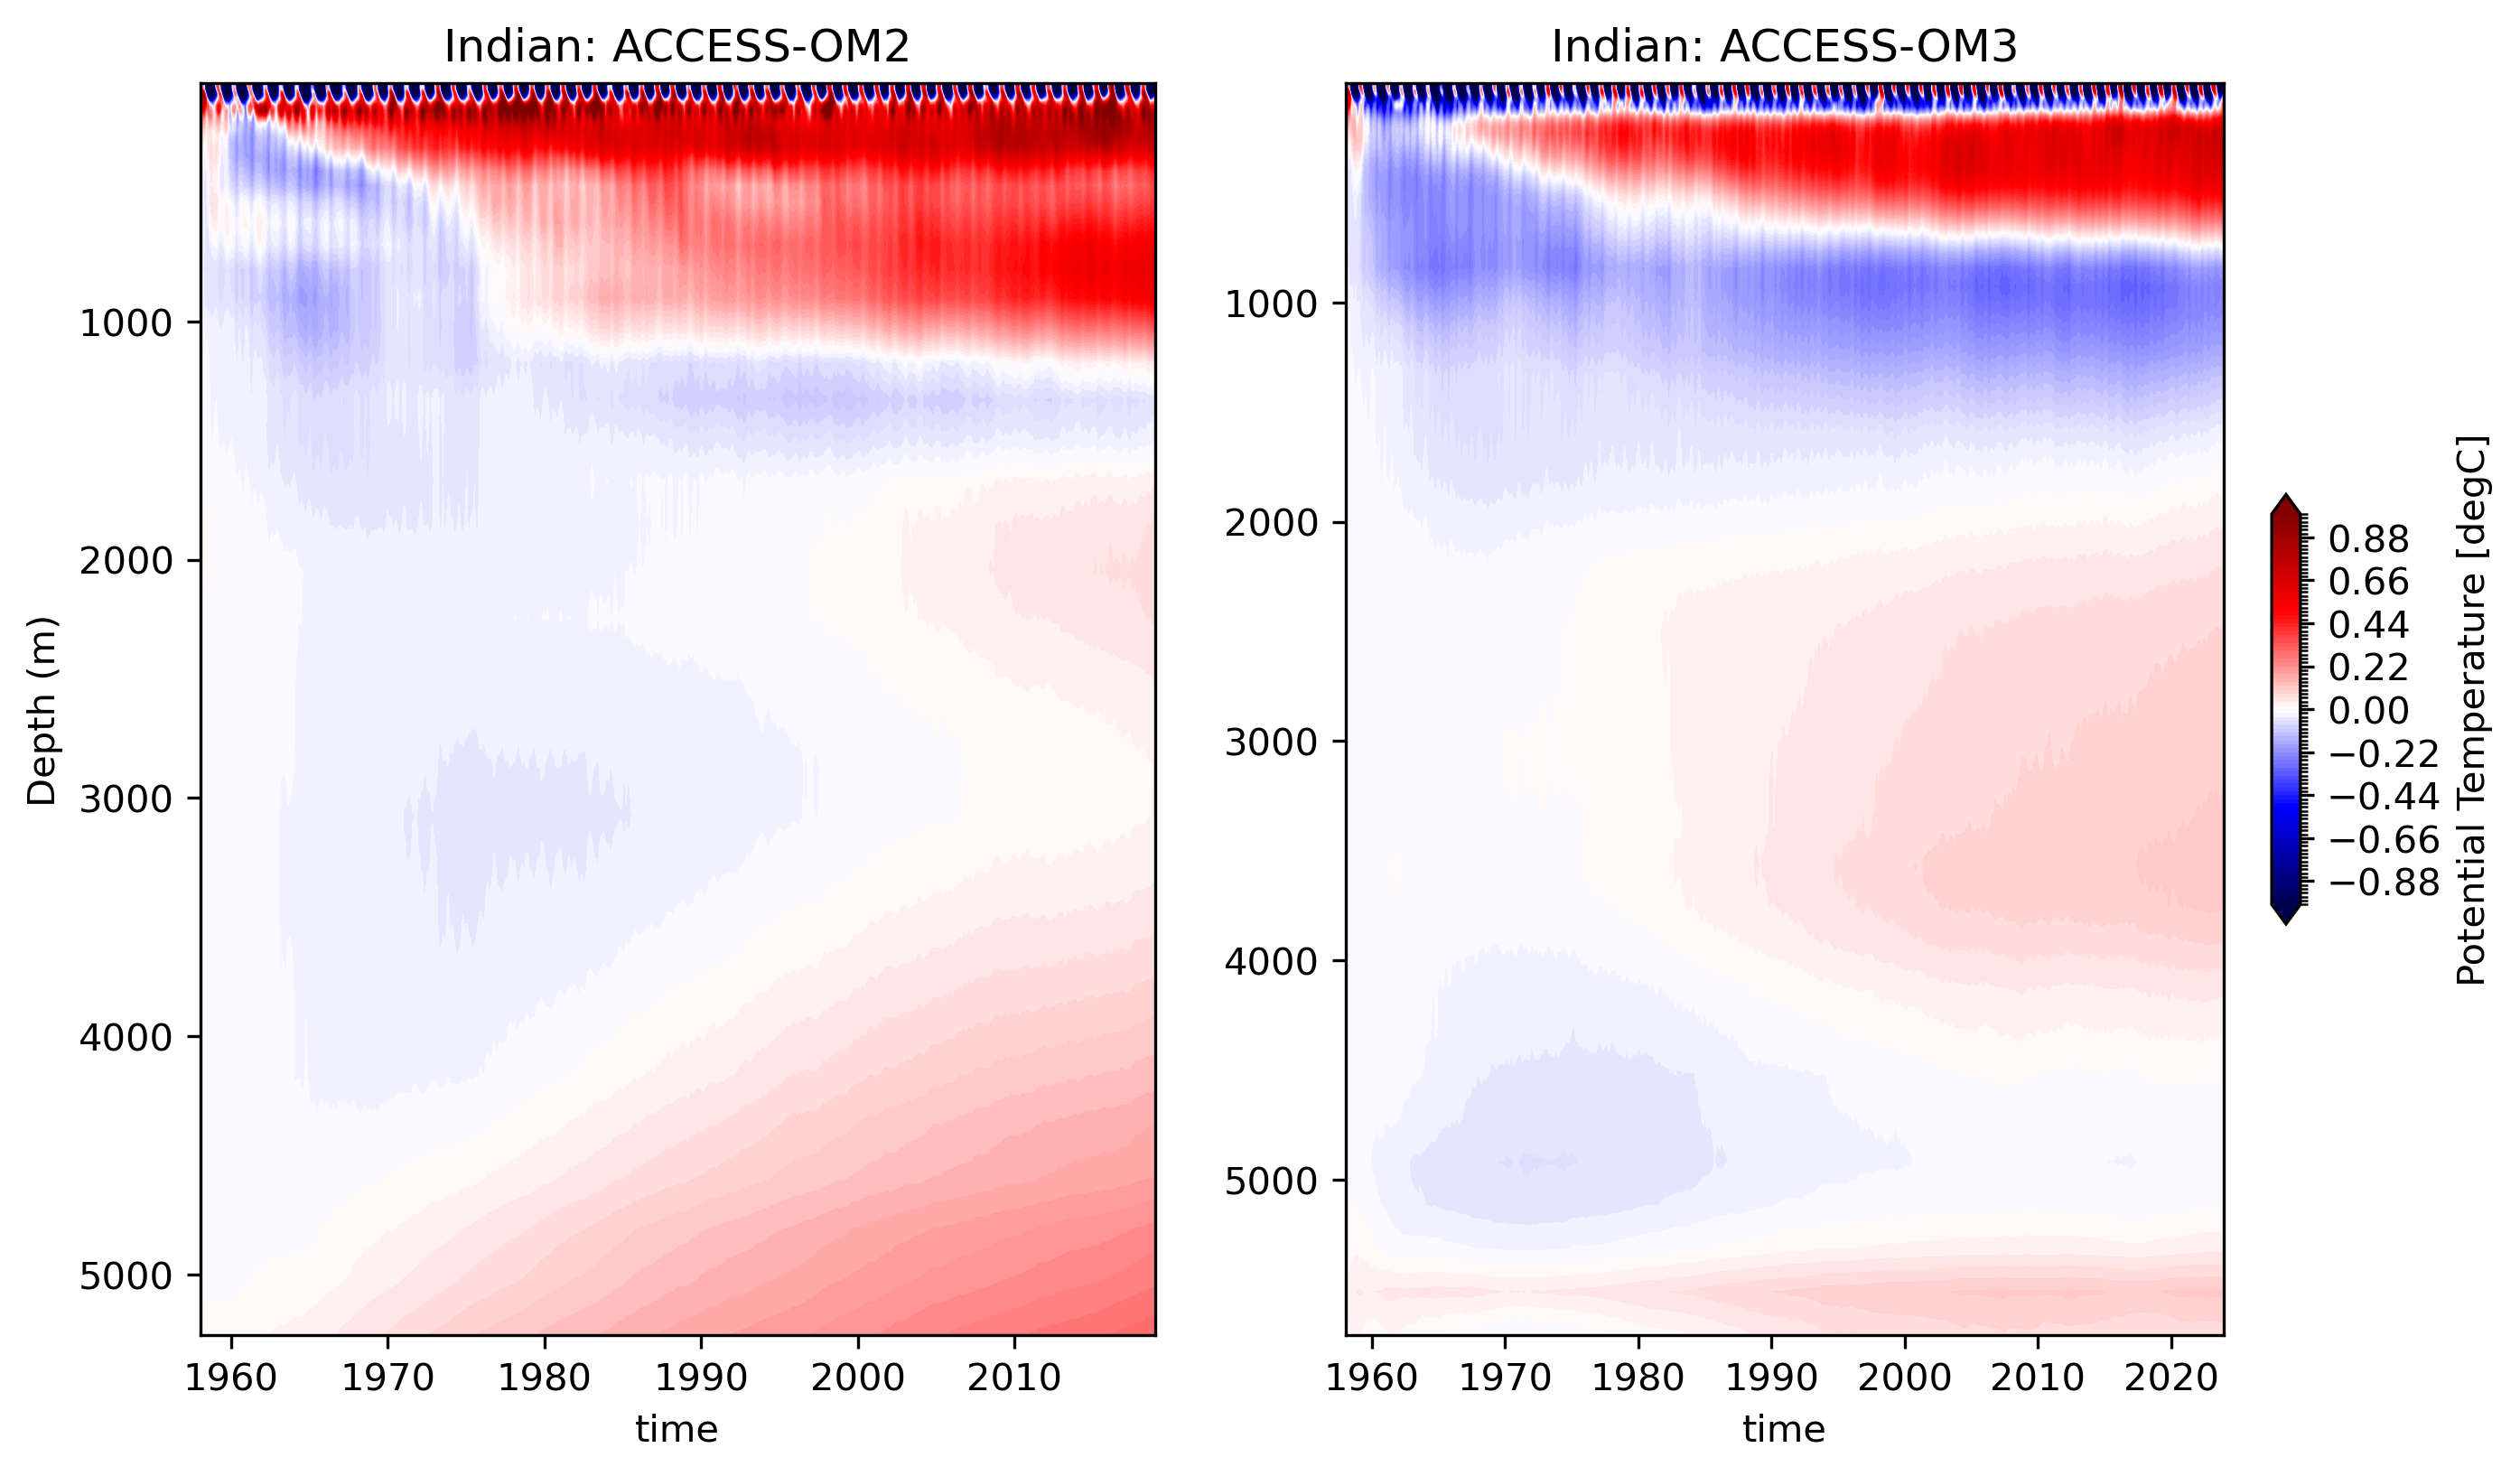

In [71]:
plt.figure(figsize=(10,6))

plt.subplot(121)
(om2model-om2model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    cmap='seismic',
    add_colorbar=False,
)
plt.gca().invert_yaxis()
plt.title('Indian: ACCESS-OM2')
plt.ylabel('Depth (m)')

plt.subplot(122)
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-1,
    vmax=1,
    extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.ylabel('')
plt.gca().invert_yaxis()
plt.title('Indian: ACCESS-OM3')

# Sulu Sea

In depth analysis of the Sulu Sea area to examine these issues:

- https://github.com/ACCESS-NRI/access-om3-configs/issues/625
- https://iilss.net/wp-content/uploads/2023/02/image-126.png

In [10]:
xslice = slice(119-360, 122-360)
yslice = slice(6, 10)

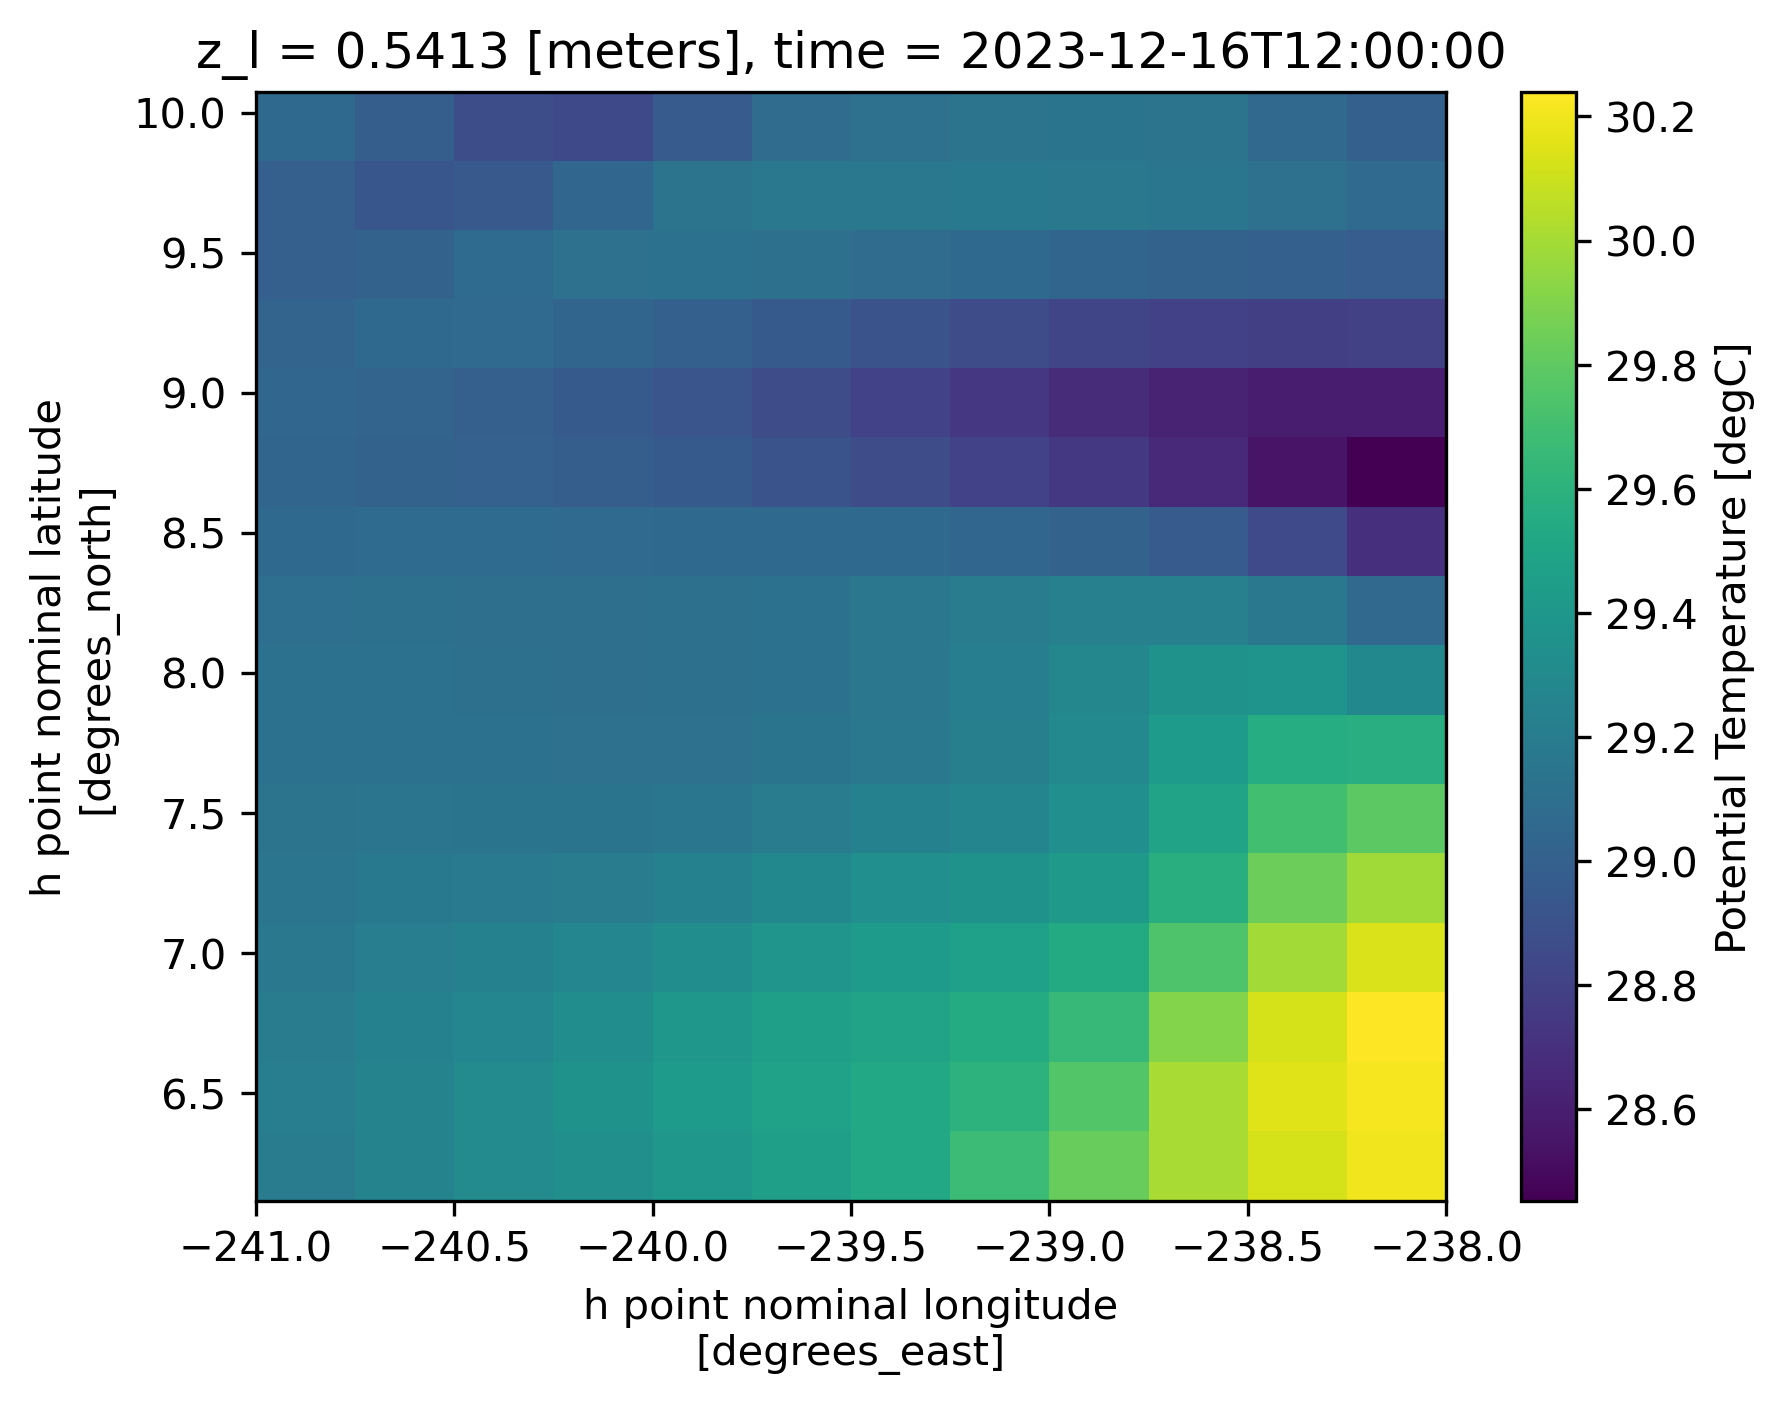

In [11]:
model_all.sel(xh=xslice).sel(yh=yslice).isel(time=-1).isel(z_l=0).plot()

In [12]:
%%time
model = model_all.sel(xh=xslice).sel(yh=yslice).mean('yh').mean('xh').load()

CPU times: user 4.58 s, sys: 1.37 s, total: 5.95 s
Wall time: 17 s


Text(0.5, 1.0, 'Sulu Sea UNWEIGHTED Horizontal mean Potential Temperature\ndrift from initial condition in 25km-iaf-test-for-AK-\nexpt-7df5ef4c')

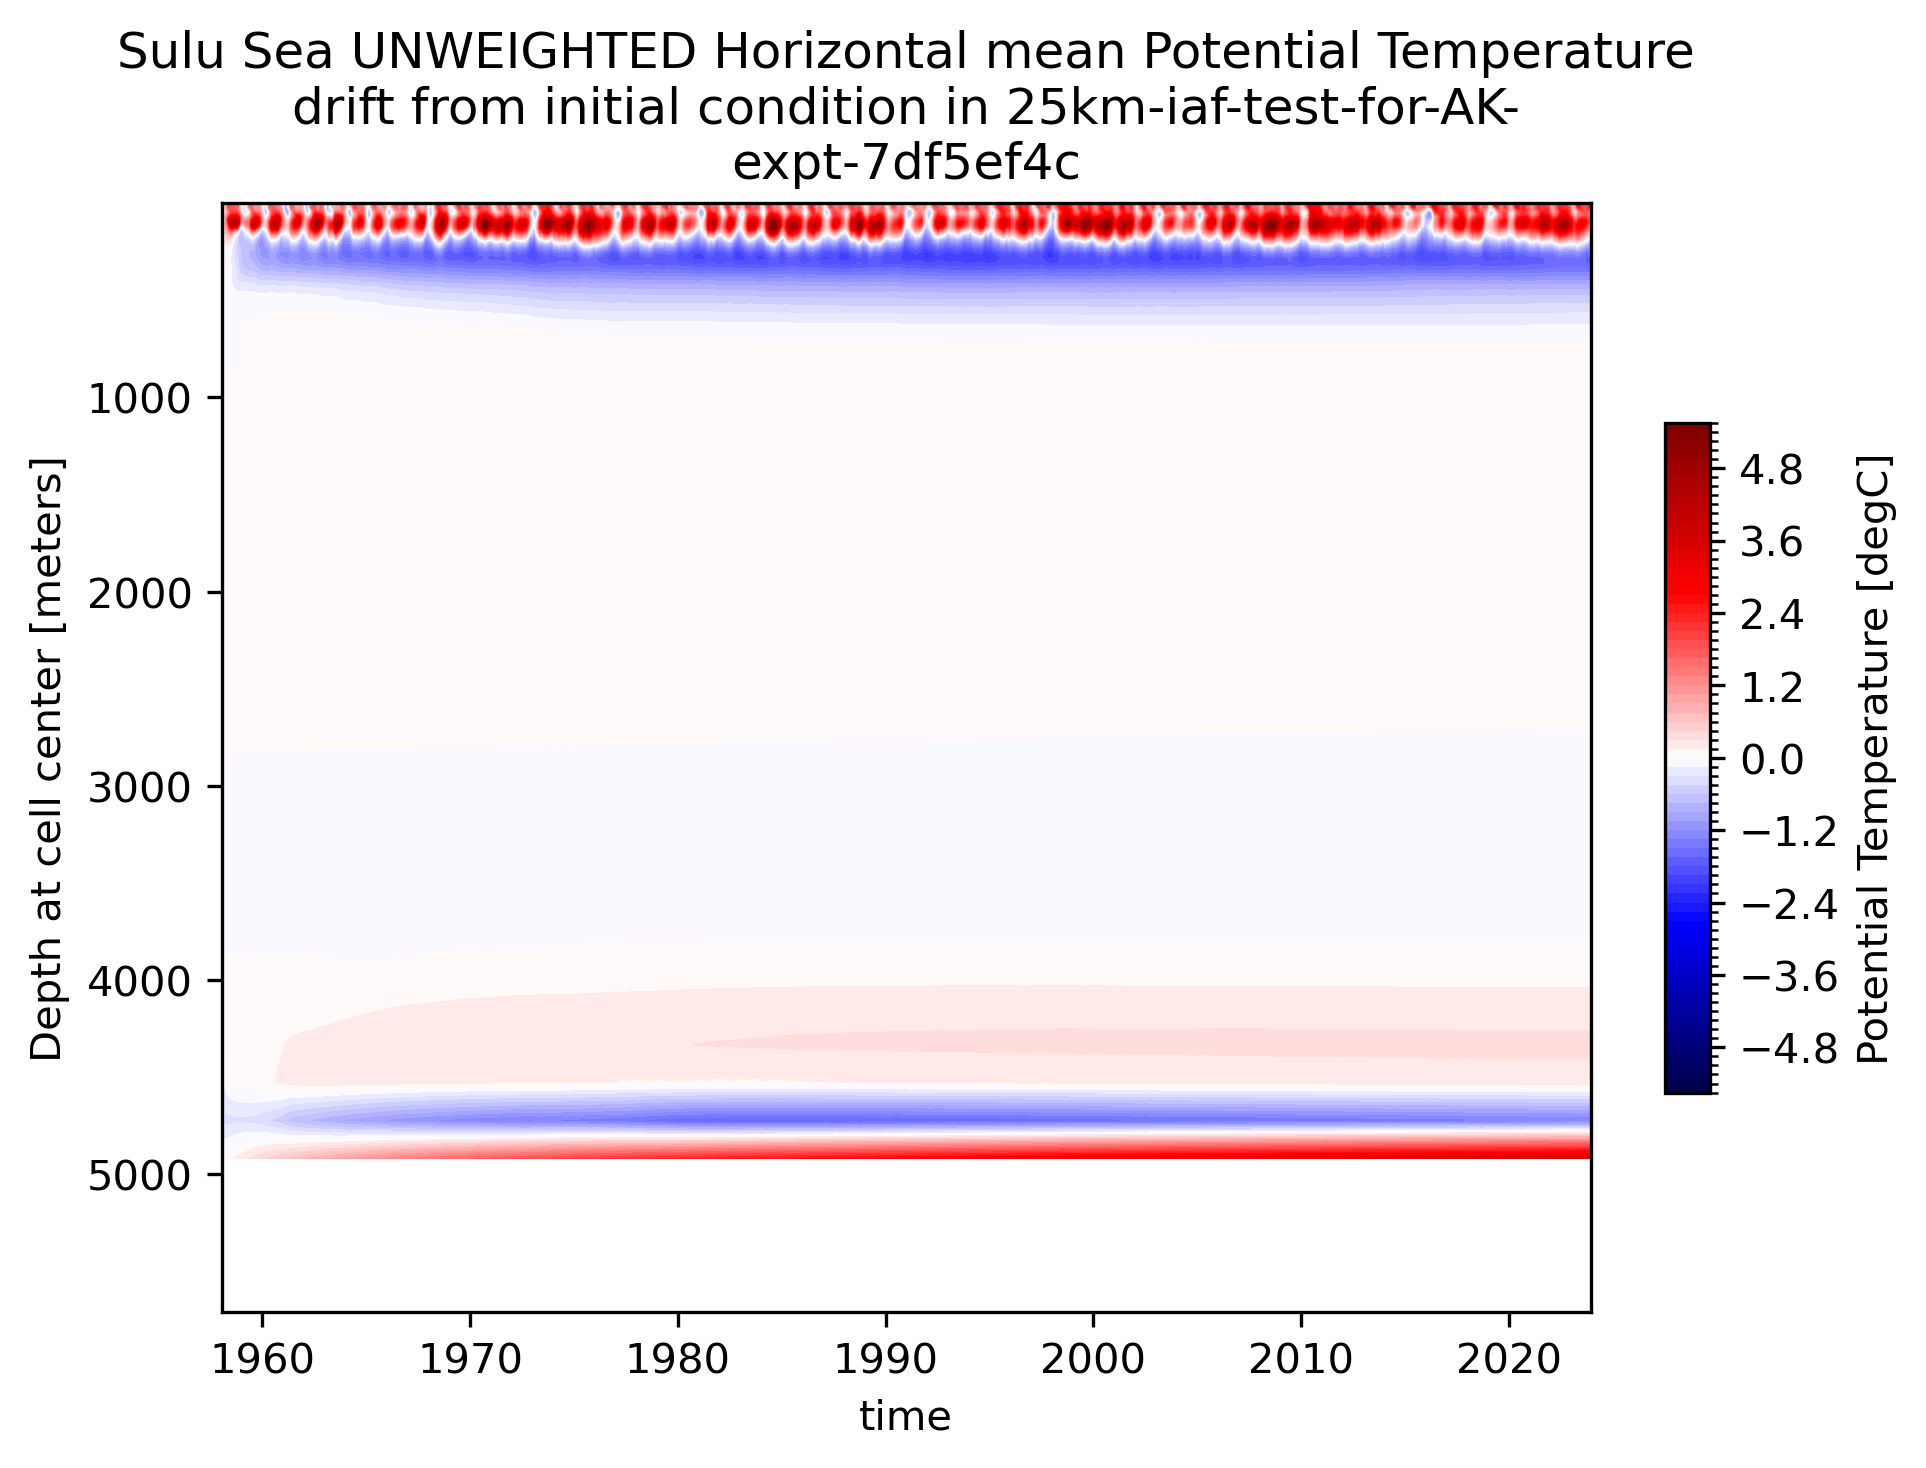

In [15]:
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    # vmin=-1,
    # vmax=1,
    # extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.gca().invert_yaxis()
plt.title("\n".join(wrap(f"Sulu Sea UNWEIGHTED Horizontal mean {model.attrs['long_name']} drift from initial condition in {exptname}", 60)))


In [ ]:
client.close()